# Initialize

In [7]:
# !pip install -r req

In [1]:
import os
import re
import time
import pickle
import random
import math
from typing import List, Dict, Tuple
from collections import defaultdict, Counter
from datetime import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist

from xgboost import XGBRegressor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertModel, get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import warnings
warnings.filterwarnings("ignore")

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['OMP_NUM_THREADS'] = '1'



/Users/nottreepat/Downloads/boardlibagain/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.data_processing import DataPreprocessing, HOLDCOORDINATES, HOLD_ID
from utils.visualization import Visualization
from utils.feature_eng import FeatureEng
from utils.evaluation import Evaluation
from utils.encoding_experiment import ExperimentRunner, MatrixEncoder, StatsEncoder, MatrixStatsEncoder, GraphEncoder, SequenceEncoder
from utils.transformer_good_ass import KilterBERT, BoulderDataset, KilterEncoder

# Read sqlite3 - done once

In [10]:
# import os

# # Directory to save CSVs
# output_dir = "/Users/nottreepat/Downloads/boardlibagain/csv_exports"
# os.makedirs(output_dir, exist_ok=True)

# for table_name_tuple in tables:
#     table_name = table_name_tuple[0]  # tuple to string
#     try:
#         # Read table into DataFrame
#         df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        
#         # Save to CSV
#         csv_path = os.path.join(output_dir, f"{table_name}.csv")
#         df.to_csv(csv_path, index=False)
#         print(f"Saved {table_name} to {csv_path}")
#     except Exception as e:
#         print(f"Could not save table {table_name}: {e}")

# # Close connection
# conn.close()


# Data Processing

In [3]:
dp = DataPreprocessing()

# Load data
routes = dp.load_routes(cache_path='src/cleaned_routes.csv')
print(f"Dataset: {len(routes)} routes")

routes_clean = dp.clean_routes(routes)
print(f"After cleaning: {len(routes_clean)} routes")

sample = routes_clean.iloc[0]
print(routes_clean.iloc[0][['name', 'v_grade', 'letter_grade', 'angle_y', 'ascensionist_count', 'holds_data']])
# holds_data is list of {hold_id: func} 
# where func is {12: 'start', 13: 'hand', 14: 'finish', 15: 'foot'}
print(f"\n columns: {routes_clean.columns}")

Loading cached routes from src/cleaned_routes.csv...
Dataset: 61266 routes

Cleaning 61266 routes...

  Final: 61266 routes (100.0% retained)
  Saved to src/cleaned_routes.csv
After cleaning: 61266 routes
name                                                             zoumba
v_grade                                                              V5
letter_grade                                                        6c+
angle_y                                                              30
ascensionist_count                                                    8
holds_data            [{1136: 12}, {1169: 15}, {1234: 13}, {1253: 13...
Name: 0, dtype: object

 columns: Index(['uuid', 'layout_id', 'setter_id', 'setter_username', 'name',
       'description', 'hsm', 'edge_left', 'edge_right', 'edge_bottom',
       'edge_top', 'angle_x', 'frames_count', 'frames_pace', 'frames',
       'is_draft', 'is_listed', 'created_at', 'is_nomatch', 'angle_y',
       'display_difficulty', 'ascensionist_count

# Visualization

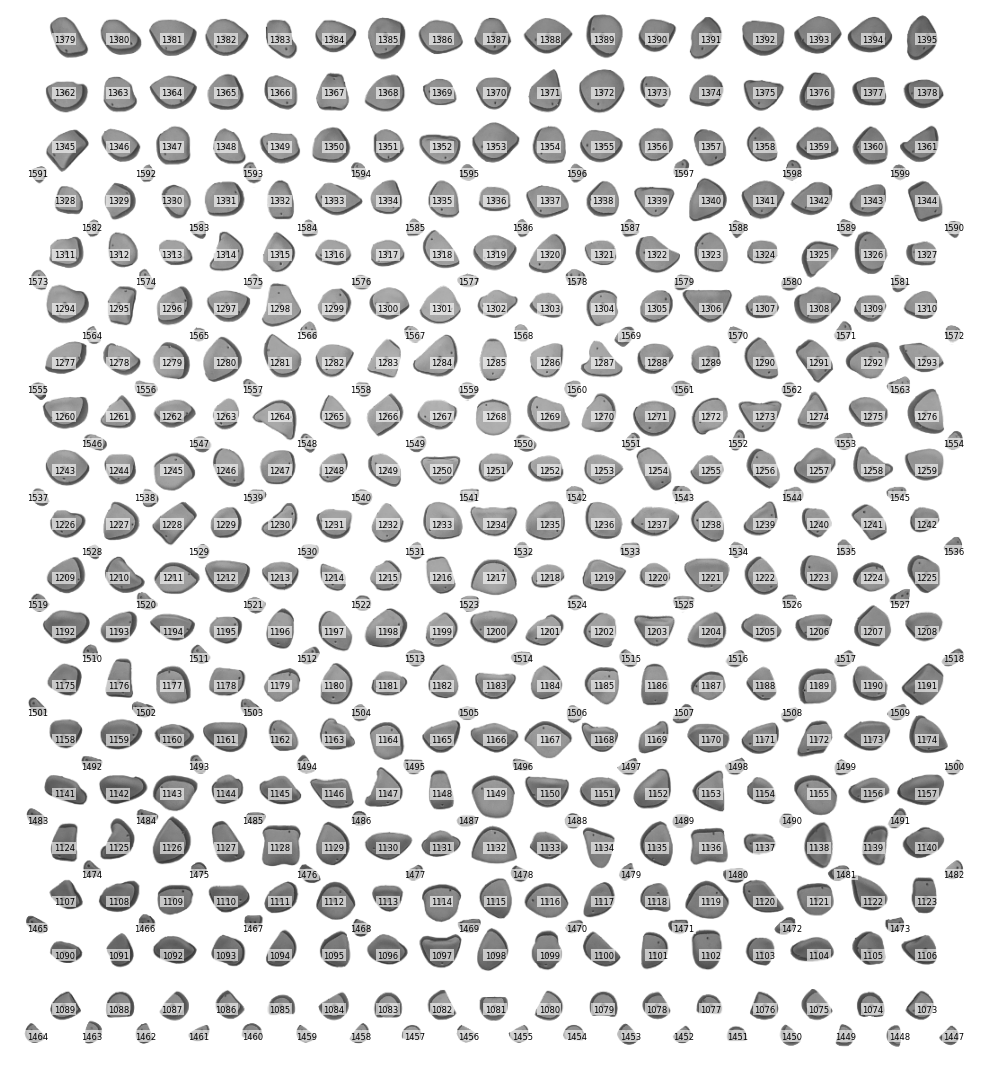

<Figure size 640x480 with 0 Axes>

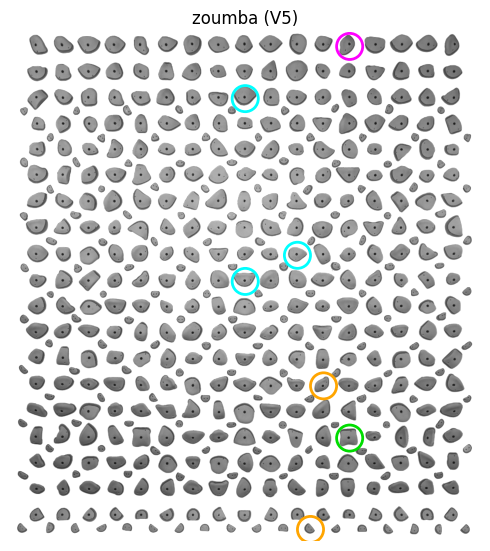

<Figure size 640x480 with 0 Axes>

In [4]:
viz = Visualization()
viz.plot_hold_ids(show_ids = True)

viz.plot_boulder(sample['holds_data'], name=sample['name'], v_grade=sample['v_grade'])

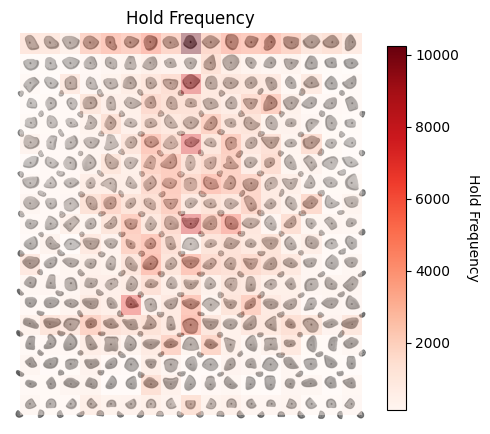

<Figure size 640x480 with 0 Axes>

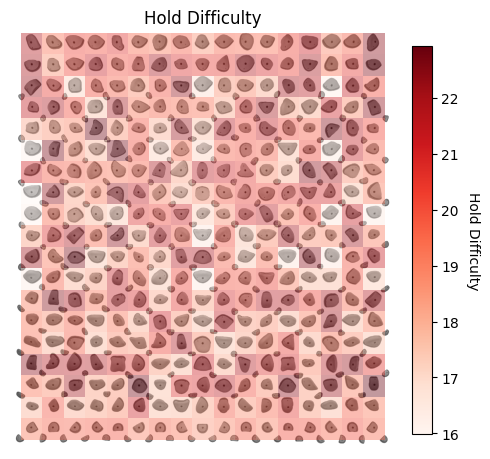

<Figure size 640x480 with 0 Axes>

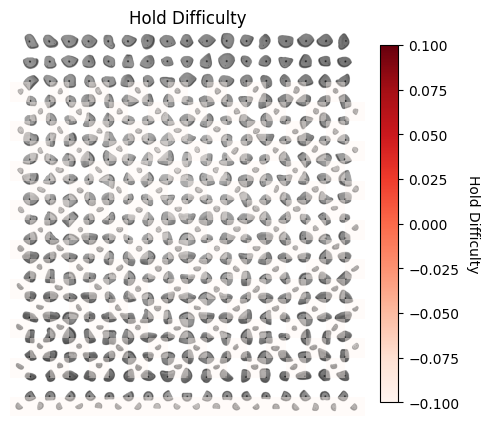

<Figure size 640x480 with 0 Axes>

In [13]:
# Hold frequency heatmap
hold_freq = defaultdict(int)
for holds in routes['holds_data']:
    for hold in holds:
        hold_freq[list(hold.keys())[0]] += 1

# Hold Difficulty heatmap
hold_difficulties = defaultdict(list)

for _, row in routes_clean.iterrows():
    difficulty = row["display_difficulty"]
    for hold in row["holds_data"]:
        hold_id = list(hold.keys())[0]  # assign first
        if hold_id < 1447:              # then check
            hold_difficulties[hold_id].append(difficulty)

# average difficulty
hold_avg_diff = {
    hold_id: (sum(vals) / len(vals) if len(vals) > 0 else 0)
    for hold_id, vals in hold_difficulties.items()
}

# Plots
viz.plot_heatmap(dict(hold_freq), title="Hold Frequency", hold_type='main')
viz.plot_heatmap(dict(hold_avg_diff), title="Hold Difficulty", hold_type='main')
viz.plot_heatmap(dict(hold_avg_diff), title="Hold Difficulty", hold_type='auxiliary')


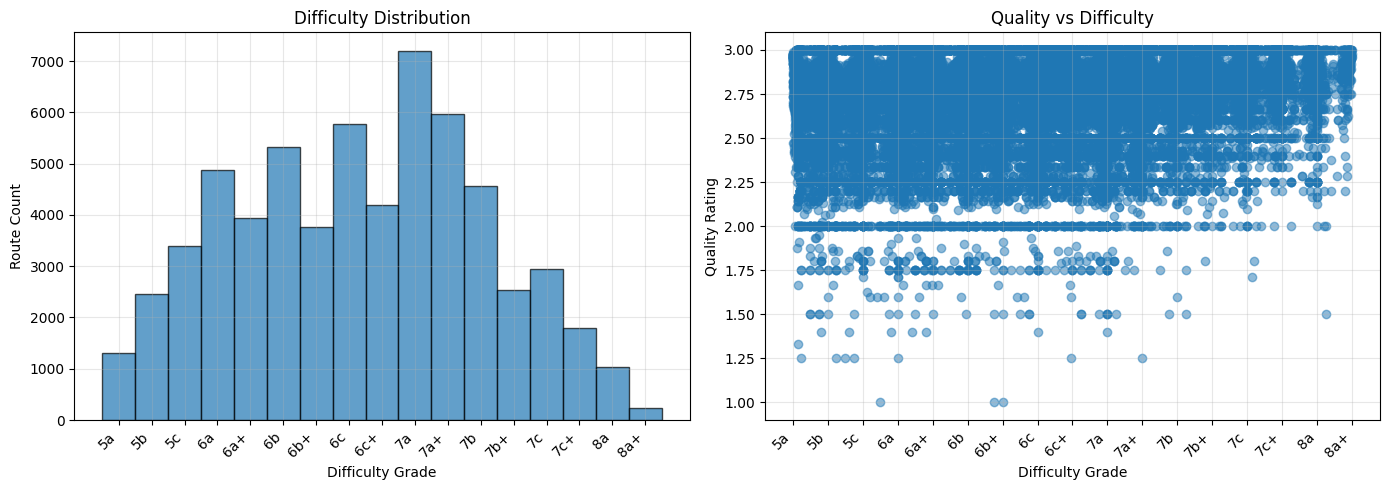

<Figure size 640x480 with 0 Axes>

In [5]:
viz.plot_difficulty_quality_analysis(routes_clean, dp)

# Stats Viz

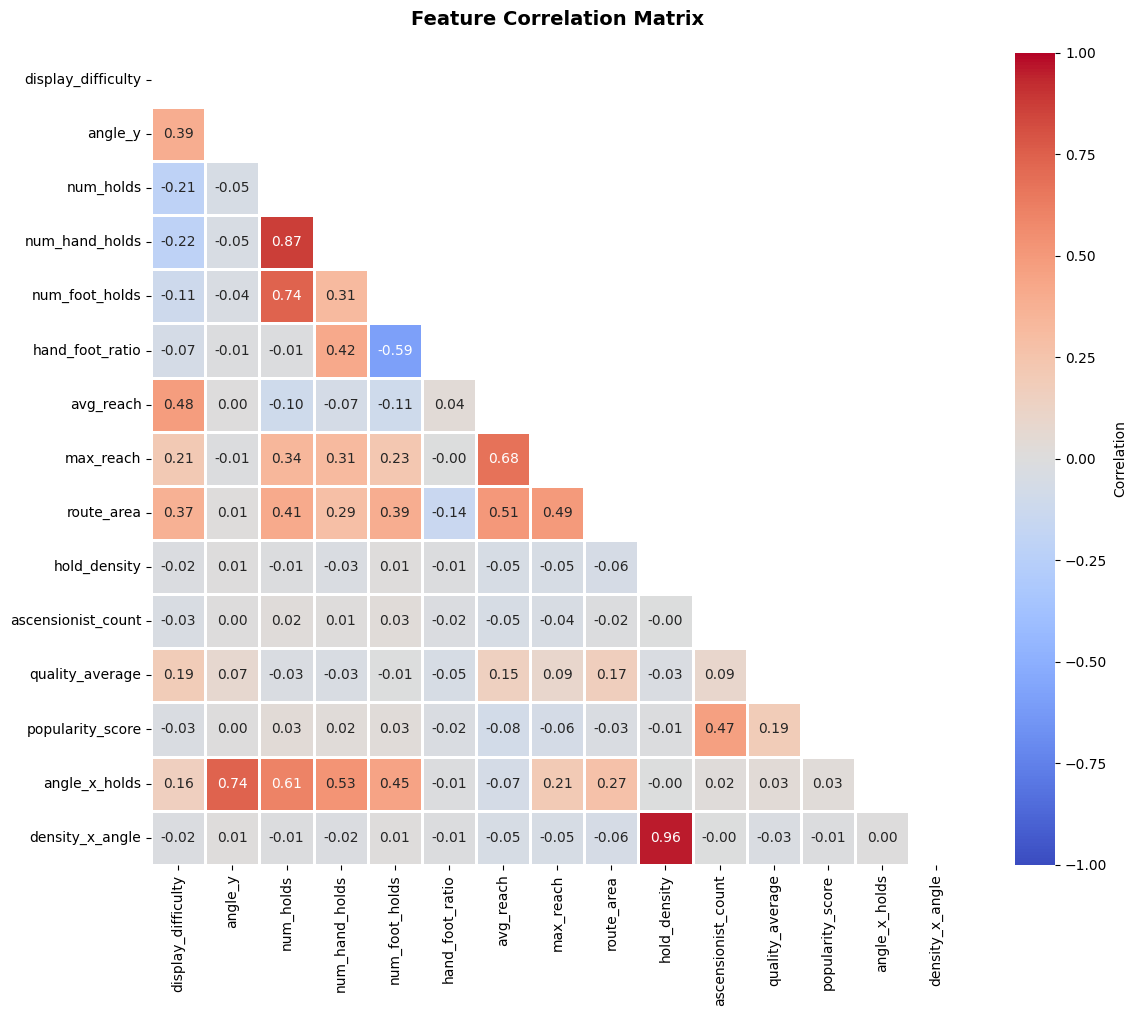

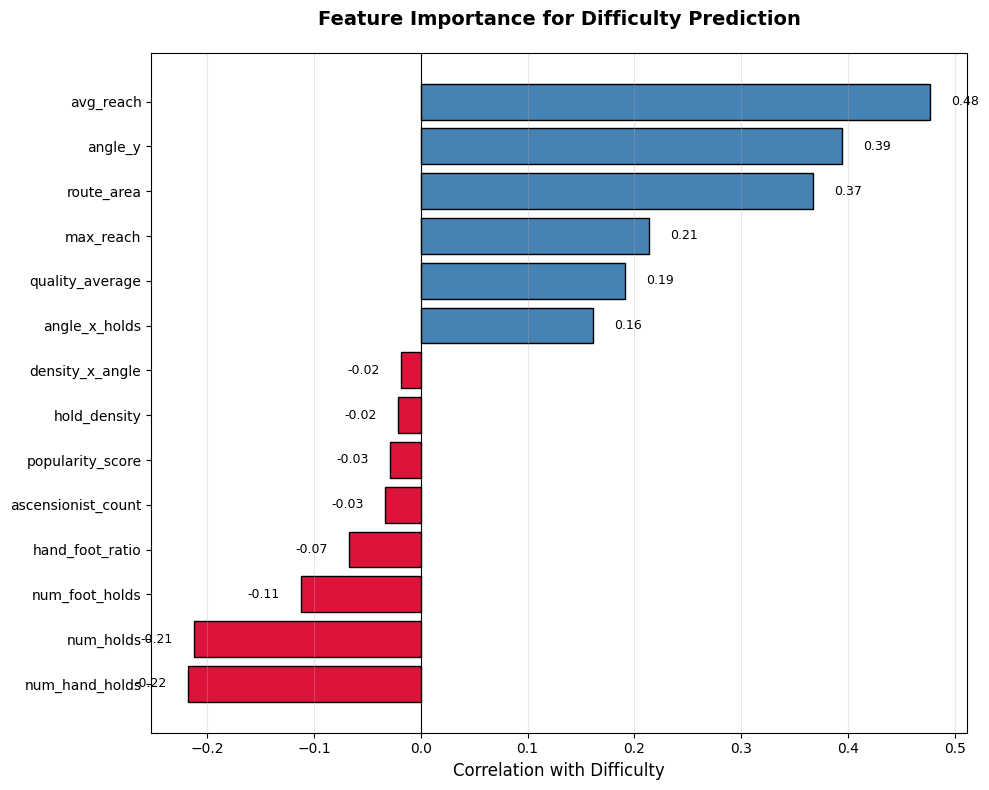

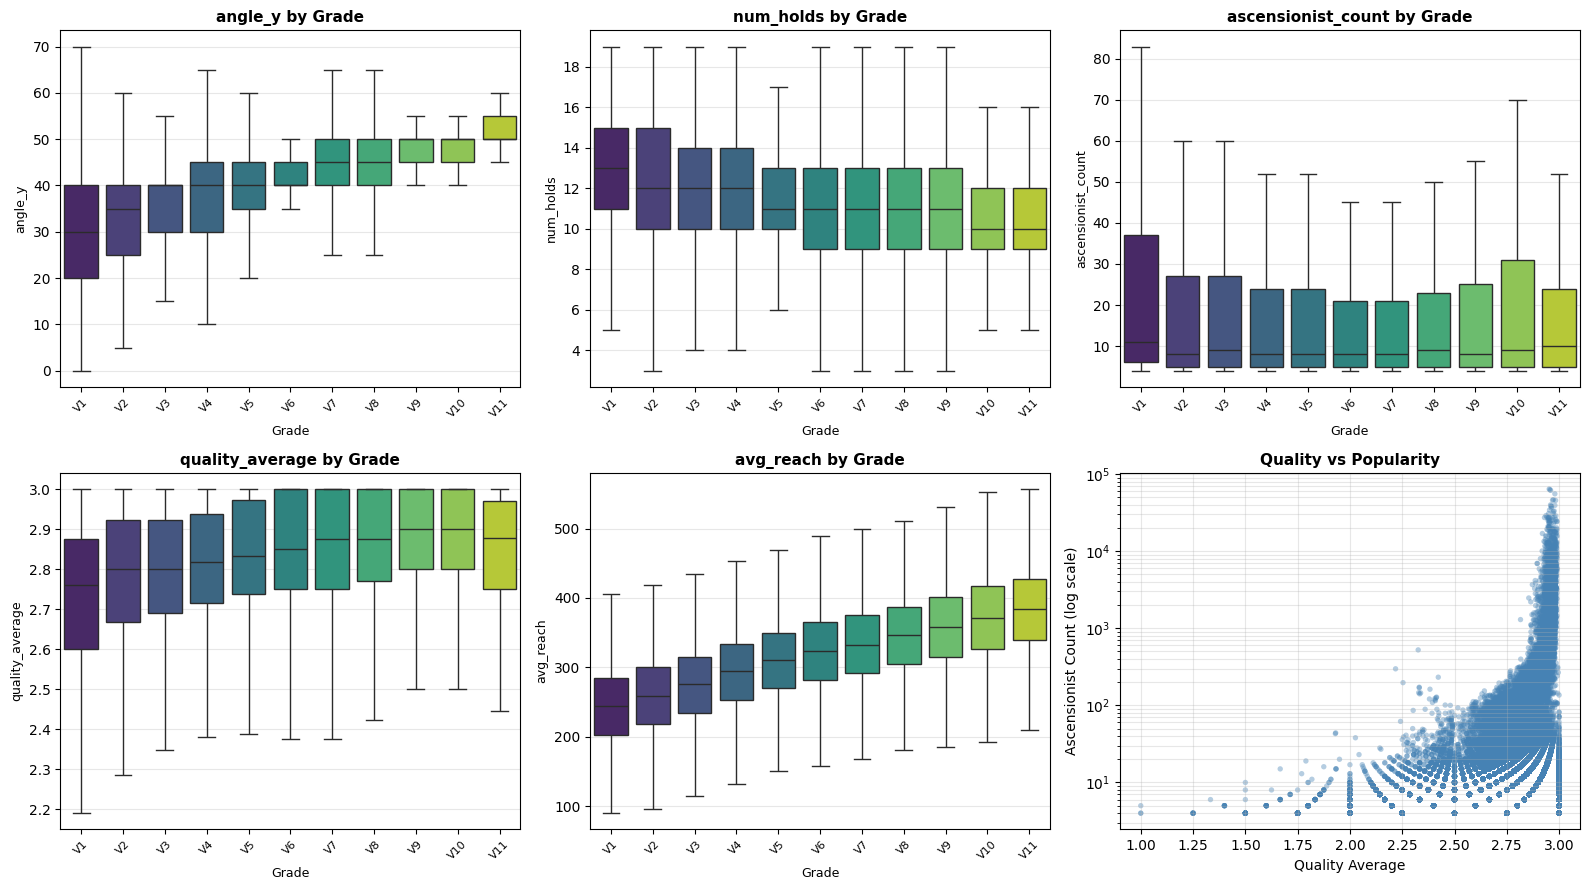

In [3]:
# fe = FeatureEng()
# routes = fe.load_data('src/cleaned_routes.csv')
# routes_with_features = fe.engineer_all_features(routes)
# fe.save_features(routes_with_features, 'src/route_features.csv')

viz = Visualization()
routes_with_features = pd.read_csv('src/route_features.csv')
viz.plot_correlation(routes_with_features)
viz.plot_corr_with_difficulty(routes_with_features)
viz.plot_distribution(routes_with_features)

# Dummy XGBoost

Loading cached routes from src/cleaned_routes.csv...

Gradient Boosting Performance:
  R²:   0.7742
  MAE:  1.5078
  RMSE: 1.9364
  Within ±1 V-grade: 76.34%


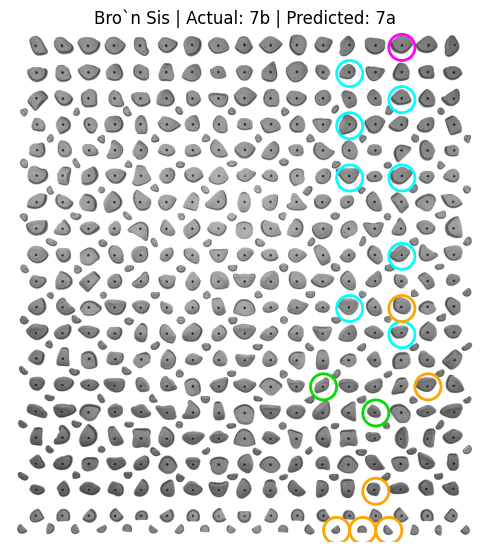

Loading cached routes from src/cleaned_routes.csv...

XGBoost Performance:
  R²:   0.7742
  MAE:  1.5078
  RMSE: 1.9364
  Within ±1 V-grade: 76.34%


<Figure size 640x480 with 0 Axes>

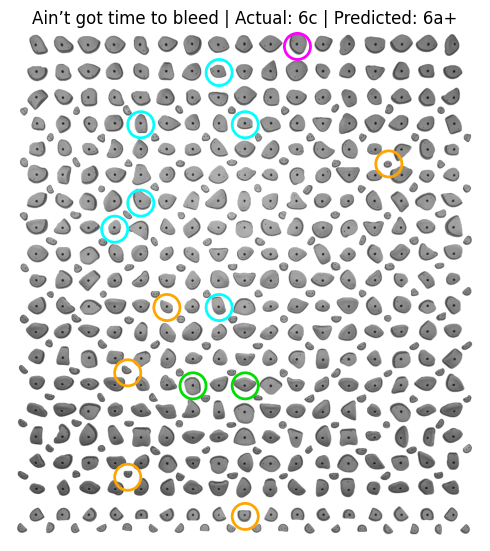

<Figure size 640x480 with 0 Axes>

In [16]:
# Initialize
dp = DataPreprocessing()
routes_df = dp.load_routes('src/cleaned_routes.csv')

# Simple feature extraction
MAX_HOLDS = 20

def extract_features(row):
    coords = []
    funcs = []
    
    for hold in row['holds_data'][:MAX_HOLDS]:
        hold_id, func = list(hold.items())[0]
        if hold_id in HOLD_ID:
            idx = HOLD_ID.index(hold_id)
            x, y = HOLDCOORDINATES[idx]
            coords.extend([x, y])
        else:
            coords.extend([0, 0])
        funcs.append(func)
    
    # Pad to MAX_HOLDS
    coords.extend([0, 0] * (MAX_HOLDS - len(funcs)))
    funcs.extend([0] * (MAX_HOLDS - len(funcs)))
    
    angle = row.get('angle_y', 0)
    return coords + funcs + [len(row['holds_data']), angle if not pd.isna(angle) else 0]

# Prepare data
X = routes_df.apply(extract_features, axis=1, result_type='expand').fillna(0)
y = routes_df['display_difficulty']


# Split and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=routes_df['v_grade']
)

model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate using existing utils
y_pred = model.predict(X_test)

evaluator = Evaluation(dp)
scores = evaluator.get_scores(y_test, y_pred, "Gradient Boosting")

# Plot
# evaluator.plot_predictions(y_test, y_pred)
# evaluator.plot_residuals(y_test, y_pred)


idx = 0
route = test_df.reset_index(drop=True).iloc[idx]
actual_diff = y_test.iloc[idx]
pred_diff = y_pred[idx]
actual_v = dp.difficulty_to_grades(int(round(actual_diff)))[0]
pred_v = dp.difficulty_to_grades(int(round(pred_diff)))[0]
    

viz.plot_boulder(route['holds_data'], name = route['name'], v_grade = actual_v, predicted_v_grade = pred_v)
# Initialize
dp = DataPreprocessing()
routes_df = dp.load_routes('src/cleaned_routes.csv')

# Simple feature extraction
MAX_HOLDS = 20

def extract_features(row):
    coords = []
    funcs = []
    
    for hold in row['holds_data'][:MAX_HOLDS]:
        hold_id, func = list(hold.items())[0]
        if hold_id in HOLD_ID:
            idx = HOLD_ID.index(hold_id)
            x, y = HOLDCOORDINATES[idx]
            coords.extend([x, y])
        else:
            coords.extend([0, 0])
        funcs.append(func)
    
    # Pad to MAX_HOLDS
    coords.extend([0, 0] * (MAX_HOLDS - len(funcs)))
    funcs.extend([0] * (MAX_HOLDS - len(funcs)))
    
    angle = row.get('angle_y', 0)
    return coords + funcs + [len(row['holds_data']), angle if not pd.isna(angle) else 0]

# Prepare data
X = routes_df.apply(extract_features, axis=1, result_type='expand').fillna(0)
y = routes_df['display_difficulty']

# Split data AND dataframe
X_train, X_test, y_train, y_test, train_df, test_df = train_test_split(
    X, y, routes_df, test_size=0.2, random_state=42, stratify=routes_df['v_grade']
)

model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

evaluator = Evaluation(dp)
scores = evaluator.get_scores(y_test, y_pred, "XGBoost")


idx = np.random.randint(0, len(y_test))
route = test_df.reset_index(drop=True).iloc[idx]
actual_diff = y_test.iloc[idx]
pred_diff = y_pred[idx]
actual_v = dp.difficulty_to_grades(int(round(actual_diff)))[0]
pred_v = dp.difficulty_to_grades(int(round(pred_diff)))[0]

viz.plot_boulder(route['holds_data'], name=route['name'], v_grade=actual_v, predicted_v_grade=pred_v)

# Clustering

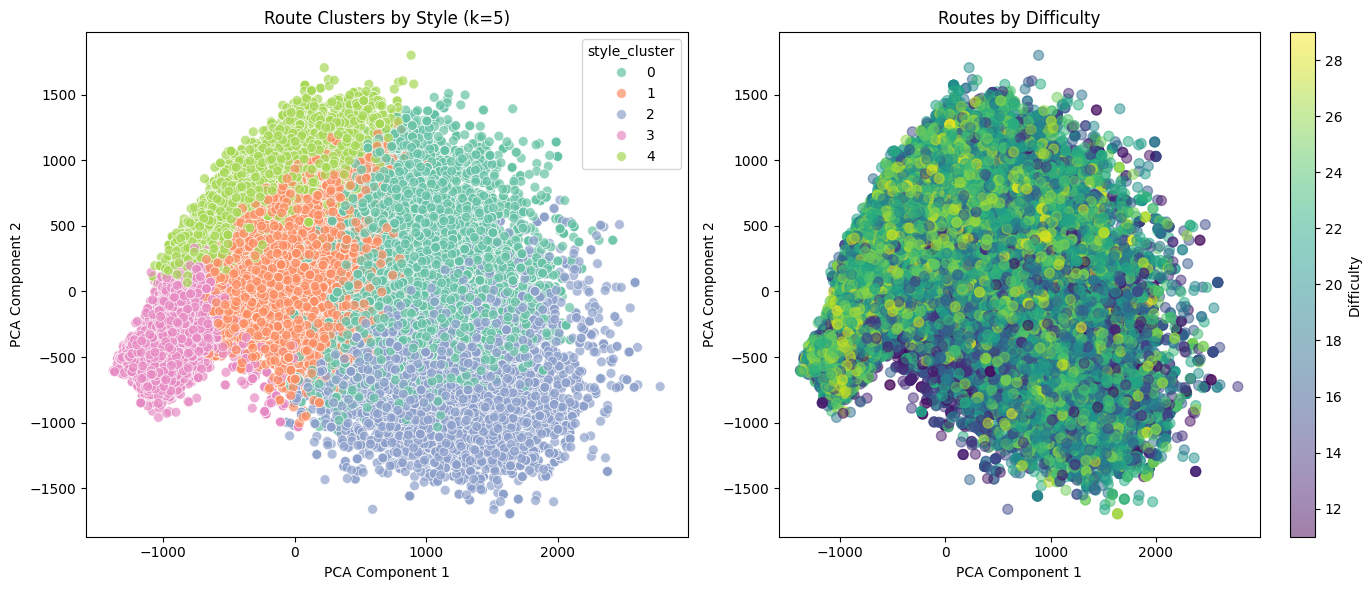


Cluster 0: V4-V6 Circuit #5 | V6c | 40°


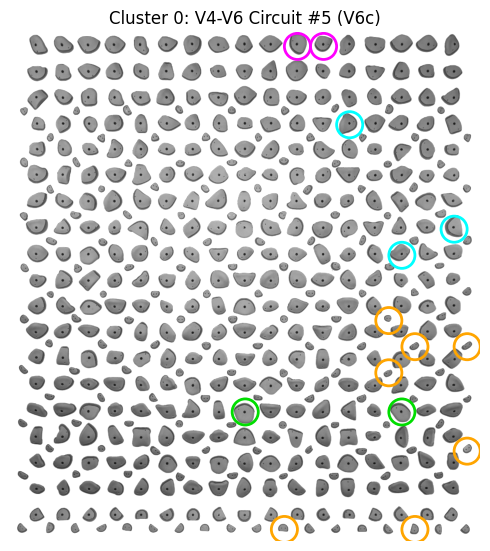


Cluster 1: campus for your life bro | V6b | 45°


<Figure size 640x480 with 0 Axes>

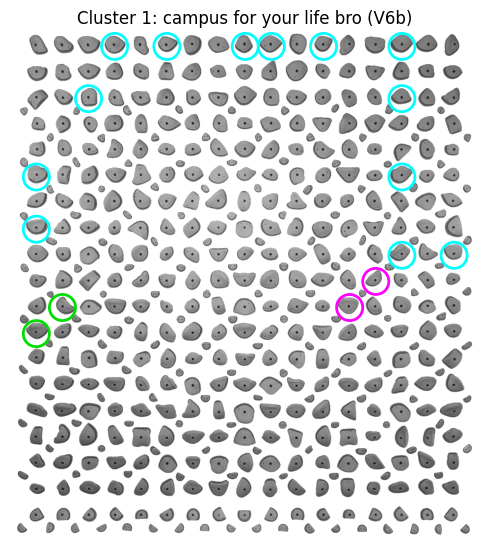

<Figure size 640x480 with 0 Axes>

In [17]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
routes_df["style_cluster"] = kmeans.fit_predict(X)

# viz.plot_clustering(X, routes_df, cluster_col='style_cluster')

# Show only 3 representatives with boulders
viz.plot_clustering(X, routes_df, cluster_col='style_cluster', 
                   n_representatives=2, plot_boulders=True)


# Encoding Experiment

In [19]:
runner = ExperimentRunner(dp)
results = []
xgb = XGBRegressor(n_estimators=100, random_state=42)

# Experiment 1: Matrix + XGBoost
results.append(runner.run(
    MatrixEncoder(grid_size=(48, 48)),
    xgb, routes, "Matrix + XGBoost"))

# Experiment 2: Stats + XGBoost
results.append(runner.run(
    StatsEncoder(),
    xgb, routes, "Stats + XGBoost"))

# Experiment 3: Matrix + Stats + XGBoost
results.append(runner.run(
    MatrixStatsEncoder(grid_size=(48, 48)),
    xgb, routes, "Matrix+Stats + XGBoost"))

# Experiment 4: Graph + XGBoost
results.append(runner.run(
    GraphEncoder(),
    xgb, routes, "Graph + XGBoost"))

# Experiment 5: Sequence + XGBoost
results.append(runner.run(
    SequenceEncoder(max_holds=20),
    xgb, routes, "Sequence + XGBoost"))

# Compare all
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
comparison = pd.DataFrame([
    {
        'Method': r['name'],
        'R²': r['scores']['r2'],
        'MAE': r['scores']['mae'],
        'RMSE': r['scores']['rmse'],
        'Train Time (s)': r['train_time'],
    }
    for r in results
])
print(comparison.to_string(index=False))


Experiment: Matrix + XGBoost
Encoding features...
Feature shape: (64573, 9217)
Training model...
Training time: 143.81s

Matrix + XGBoost Performance:
  R²:   0.7339
  MAE:  1.6442
  RMSE: 2.1021
  Within ±1 V-grade: 72.46%

Experiment: Stats + XGBoost
Encoding features...
Feature shape: (64573, 18)
Training model...
Training time: 29.01s

Stats + XGBoost Performance:
  R²:   0.6561
  MAE:  1.8742
  RMSE: 2.3898
  Within ±1 V-grade: 66.86%

Experiment: Matrix+Stats + XGBoost
Encoding features...
Feature shape: (64573, 9235)
Training model...
Training time: 173.22s

Matrix+Stats + XGBoost Performance:
  R²:   0.8126
  MAE:  1.3773
  RMSE: 1.7642
  Within ±1 V-grade: 79.50%

Experiment: Graph + XGBoost
Encoding features...
Feature shape: (64573, 16)
Training model...
Training time: 274.83s

Graph + XGBoost Performance:
  R²:   0.4162
  MAE:  2.5011
  RMSE: 3.1137
  Within ±1 V-grade: 54.12%

Experiment: Sequence + XGBoost
Encoding features...
Feature shape: (64573, 16)
Training model...

# GOOD ASS Transformer

In [20]:
dp = DataPreprocessing()
routes = dp.load_routes()
print(f"Dataset: {len(routes)} routes")

# Split into train, val, test
train_df, test_df = train_test_split( routes, test_size=0.15, random_state=42,
    stratify=routes['v_grade'])
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42,  # 0.125 of 0.8 = 0.1 of total
    stratify=train_df['v_grade'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

model_name = 'good_ass_transformer'
encoder = KilterEncoder(model_name='good_ass_transformer', hidden_dim=128, num_layers=4)
print(f"Vocabulary size: {encoder.vocab_size}")
print(f"Model parameters: {sum(p.numel() for p in encoder.model.parameters()):,}")
print(f"Device: {encoder.device}")

encoder.train_model(train_df, val_df, epochs=30, batch_size=64, lr=2e-4)

Loading cached routes from src/cleaned_routes.csv...
Dataset: 64573 routes
Train: 48026, Val: 6861, Test: 9686
Vocabulary size: 955
Model parameters: 962,049
Device: cpu
Training good_ass_transformer ...


Epoch 1/30: 100%|██████████| 751/751 [03:36<00:00,  3.46it/s]


Epoch 1: Train Loss=5.5474, Val Loss=2.8981, LR=6.67e-05


Epoch 2/30: 100%|██████████| 751/751 [03:34<00:00,  3.50it/s]


Epoch 2: Train Loss=1.9164, Val Loss=1.3873, LR=1.33e-04


Epoch 3/30: 100%|██████████| 751/751 [03:40<00:00,  3.41it/s]


Epoch 3: Train Loss=1.5675, Val Loss=1.4064, LR=2.00e-04


Epoch 4/30: 100%|██████████| 751/751 [03:45<00:00,  3.32it/s]


Epoch 4: Train Loss=1.5239, Val Loss=1.3945, LR=1.93e-04


Epoch 5/30: 100%|██████████| 751/751 [03:38<00:00,  3.43it/s]


Epoch 5: Train Loss=1.4595, Val Loss=1.2463, LR=1.85e-04


Epoch 6/30: 100%|██████████| 751/751 [03:36<00:00,  3.47it/s]


Epoch 6: Train Loss=1.3899, Val Loss=1.3764, LR=1.78e-04


Epoch 7/30: 100%|██████████| 751/751 [03:19<00:00,  3.77it/s]


Epoch 7: Train Loss=1.3464, Val Loss=1.2883, LR=1.70e-04


Epoch 8/30: 100%|██████████| 751/751 [03:38<00:00,  3.44it/s]


Epoch 8: Train Loss=1.2837, Val Loss=1.1172, LR=1.63e-04


Epoch 9/30: 100%|██████████| 751/751 [03:37<00:00,  3.45it/s]


Epoch 9: Train Loss=1.2454, Val Loss=1.1028, LR=1.56e-04


Epoch 10/30: 100%|██████████| 751/751 [03:35<00:00,  3.48it/s]


Epoch 10: Train Loss=1.2096, Val Loss=1.0983, LR=1.48e-04


Epoch 11/30: 100%|██████████| 751/751 [03:20<00:00,  3.75it/s]


Epoch 11: Train Loss=1.1797, Val Loss=1.0894, LR=1.41e-04


Epoch 12/30: 100%|██████████| 751/751 [03:21<00:00,  3.73it/s]


Epoch 12: Train Loss=1.1272, Val Loss=1.0725, LR=1.33e-04


Epoch 13/30: 100%|██████████| 751/751 [03:20<00:00,  3.75it/s]


Epoch 13: Train Loss=1.1151, Val Loss=1.0255, LR=1.26e-04


Epoch 14/30: 100%|██████████| 751/751 [03:20<00:00,  3.74it/s]


Epoch 14: Train Loss=1.0865, Val Loss=1.0046, LR=1.19e-04


Epoch 15/30: 100%|██████████| 751/751 [03:20<00:00,  3.75it/s]


Epoch 15: Train Loss=1.0662, Val Loss=0.9861, LR=1.11e-04


Epoch 16/30: 100%|██████████| 751/751 [03:39<00:00,  3.41it/s]


Epoch 16: Train Loss=1.0431, Val Loss=0.9489, LR=1.04e-04


Epoch 17/30: 100%|██████████| 751/751 [03:32<00:00,  3.54it/s]


Epoch 17: Train Loss=1.0336, Val Loss=0.9332, LR=9.63e-05


Epoch 18/30: 100%|██████████| 751/751 [03:39<00:00,  3.42it/s]


Epoch 18: Train Loss=1.0052, Val Loss=1.0144, LR=8.89e-05


Epoch 19/30: 100%|██████████| 751/751 [03:39<00:00,  3.43it/s]


Epoch 19: Train Loss=0.9937, Val Loss=0.9186, LR=8.15e-05


Epoch 20/30: 100%|██████████| 751/751 [03:38<00:00,  3.43it/s]


Epoch 20: Train Loss=0.9807, Val Loss=0.9373, LR=7.41e-05


Epoch 21/30: 100%|██████████| 751/751 [03:39<00:00,  3.42it/s]


Epoch 21: Train Loss=0.9690, Val Loss=0.9405, LR=6.67e-05


Epoch 22/30: 100%|██████████| 751/751 [03:20<00:00,  3.75it/s]


Epoch 22: Train Loss=0.9570, Val Loss=0.9180, LR=5.93e-05


Epoch 23/30: 100%|██████████| 751/751 [03:20<00:00,  3.75it/s]


Epoch 23: Train Loss=0.9432, Val Loss=0.9164, LR=5.19e-05


Epoch 24/30: 100%|██████████| 751/751 [03:26<00:00,  3.63it/s]


Epoch 24: Train Loss=0.9370, Val Loss=0.8979, LR=4.44e-05


Epoch 25/30: 100%|██████████| 751/751 [03:38<00:00,  3.43it/s]


Epoch 25: Train Loss=0.9228, Val Loss=0.8970, LR=3.70e-05


Epoch 26/30: 100%|██████████| 751/751 [03:38<00:00,  3.43it/s]


Epoch 26: Train Loss=0.9195, Val Loss=0.8956, LR=2.96e-05


Epoch 27/30: 100%|██████████| 751/751 [03:32<00:00,  3.54it/s]


Epoch 27: Train Loss=0.9024, Val Loss=0.9324, LR=2.22e-05


Epoch 28/30: 100%|██████████| 751/751 [03:20<00:00,  3.75it/s]


Epoch 28: Train Loss=0.8974, Val Loss=0.9057, LR=1.48e-05


Epoch 29/30: 100%|██████████| 751/751 [03:21<00:00,  3.73it/s]


Epoch 29: Train Loss=0.8901, Val Loss=0.9013, LR=7.41e-06


Epoch 30/30: 100%|██████████| 751/751 [03:20<00:00,  3.74it/s]


Epoch 30: Train Loss=0.8848, Val Loss=0.8885, LR=0.00e+00



Evaluating on test set...

GoodAss Transformer Performance:
  R²:   0.8337
  MAE:  1.2669
  RMSE: 1.6621
  Within ±1 V-grade: 82.73%


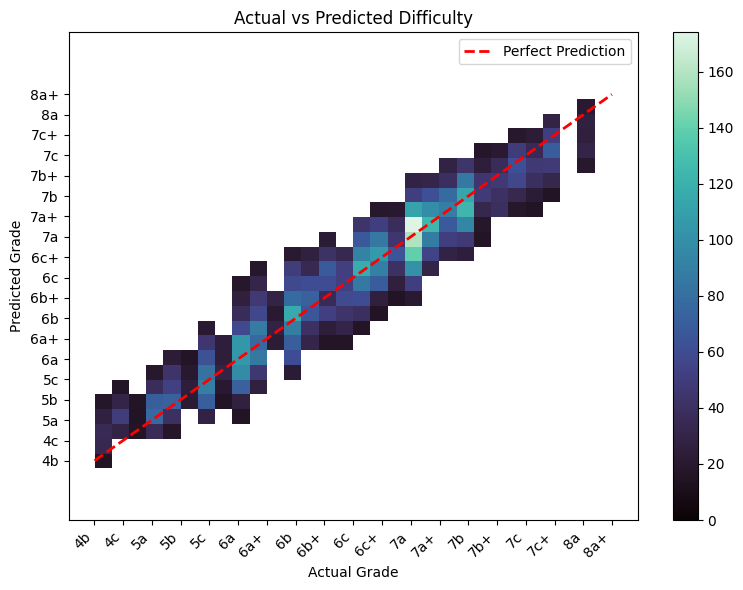

In [21]:
# Load best model
encoder.load_model('good_ass_transformer.pt')

# Evaluate
print("\nEvaluating on test set...")
y_test = test_df['display_difficulty'].values
y_pred = encoder.predict(test_df)

evaluator = Evaluation(dp)
scores = evaluator.get_scores(y_test, y_pred, "GoodAss Transformer")

evaluator.plot_predictions(y_test, y_pred)  

# Improve จิงละ

Loading cached routes from src/cleaned_routes.csv...
Loaded 64573 routes
Train: 48026 | Val: 6861 | Test: 9686

Model: enhanced_transformer
Vocabulary size: 955
Max sequence length: 25

Total parameters: 980,993
Trainable parameters: 980,993
Model size: 3.74 MB

Architecture:
  bert: 945,152 parameters
  pos_x_embed: 1,152 parameters
  pos_y_embed: 768 parameters
  angle_proj: 256 parameters
  metadata_proj: 384 parameters
  regressor: 33,281 parameters

Training enhanced_transformer


Epoch 1/30 | Train: 5.4663 | Val: 4.5086 | LR: 6.67e-05
✓ Saved best model


Epoch 2/30 | Train: 3.4006 | Val: 2.1057 | LR: 1.33e-04
✓ Saved best model


Epoch 3/30 | Train: 1.1924 | Val: 0.6612 | LR: 2.00e-04
✓ Saved best model


Epoch 4/30 | Train: 0.6283 | Val: 0.5257 | LR: 1.93e-04
✓ Saved best model


Epoch 5/30 | Train: 0.5539 | Val: 0.4766 | LR: 1.85e-04
✓ Saved best model


Epoch 6/30 | Train: 0.5172 | Val: 0.4428 | LR: 1.78e-04
✓ Saved best model


Epoch 7/30 | Train: 0.4870 | Val: 0.4171 | LR: 1.70e-04
✓ Saved best model


Epoch 8/30 | Train: 0.4616 | Val: 0.4026 | LR: 1.63e-04
✓ Saved best model


Epoch 9/30 | Train: 0.4413 | Val: 0.3726 | LR: 1.56e-04
✓ Saved best model


Epoch 10/30 | Train: 0.4272 | Val: 0.3977 | LR: 1.48e-04


Epoch 11/30 | Train: 0.4136 | Val: 0.3776 | LR: 1.41e-04


Epoch 12/30 | Train: 0.4042 | Val: 0.3648 | LR: 1.33e-04
✓ Saved best model


Epoch 13/30 | Train: 0.3941 | Val: 0.3709 | LR: 1.26e-04


Epoch 14/30 | Train: 0.3884 | Val: 0.3474 | LR: 1.19e-04
✓ Saved best model


Epoch 15/30 | Train: 0.3769 | Val: 0.3456 | LR: 1.11e-04
✓ Saved best model


Epoch 16/30 | Train: 0.3712 | Val: 0.3436 | LR: 1.04e-04
✓ Saved best model


Epoch 17/30 | Train: 0.3663 | Val: 0.3518 | LR: 9.63e-05


Epoch 18/30 | Train: 0.3607 | Val: 0.3371 | LR: 8.89e-05
✓ Saved best model


Epoch 19/30 | Train: 0.3535 | Val: 0.3334 | LR: 8.15e-05
✓ Saved best model


Epoch 20/30 | Train: 0.3511 | Val: 0.3319 | LR: 7.41e-05
✓ Saved best model


Epoch 21/30 | Train: 0.3475 | Val: 0.3291 | LR: 6.67e-05
✓ Saved best model


Epoch 22/30 | Train: 0.3425 | Val: 0.3270 | LR: 5.93e-05
✓ Saved best model


Epoch 23/30 | Train: 0.3385 | Val: 0.3265 | LR: 5.19e-05
✓ Saved best model


Epoch 24/30 | Train: 0.3337 | Val: 0.3305 | LR: 4.44e-05


Epoch 25/30 | Train: 0.3333 | Val: 0.3258 | LR: 3.70e-05
✓ Saved best model


Epoch 26/30 | Train: 0.3296 | Val: 0.3211 | LR: 2.96e-05
✓ Saved best model


Epoch 27/30 | Train: 0.3243 | Val: 0.3202 | LR: 2.22e-05
✓ Saved best model


Epoch 28/30 | Train: 0.3213 | Val: 0.3242 | LR: 1.48e-05


Epoch 29/30 | Train: 0.3193 | Val: 0.3183 | LR: 7.41e-06
✓ Saved best model


Epoch 30/30 | Train: 0.3197 | Val: 0.3190 | LR: 0.00e+00

Enhanced Spatial Transformer Performance:
  R²:   0.8270
  MAE:  1.2981
  RMSE: 1.6953
  Within ±1 V-grade: 81.17%


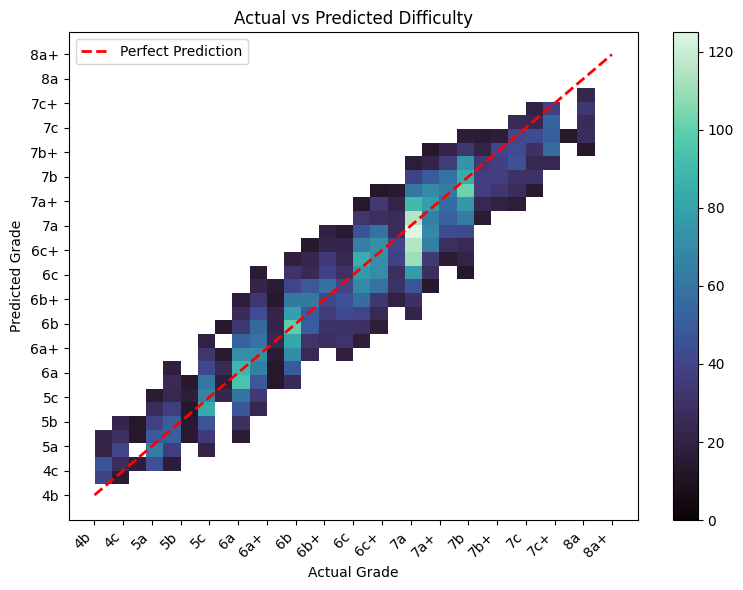


Attention weights shape: N/A


In [ ]:
"""
Enhanced Transformer for route difficulty prediction with spatial awareness.

1. ARCHITECTURE:
    - Added 2D positional embeddings (pos_x, pos_y)
    - Added other metadata features: route density, max reach distance
    - Separate _train_epoch, _validate, _compute_grade_weights
    - Added model_sumary
   
2. DATA PROCESSING:
   - hand_or_foot encoding instead of func(start, finish, hand, foot)
   - Sort holds by y and x
   - Data augmentation: shuffle of non-start/finish holds during training
   - Hold frequency by grade: Track how often each hold appears in different V-grades
   - Hold co-occurrence patterns: Capture which holds commonly appear together
   
3. TRAINING:
   - Early stopping 
   - Mixed precision training
   - Penalize errors more heavily on easier climbs (inverse grade weighting)

# 4. CODE QUALITY:
#    - Attention extraction: Return attention weights for visualization and interpretability
#    - Better error handling: Fixed v_grade string parsing for weight computation
#    - Cleaner data flow: Pop v_grade before moving tensors to device

"""
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import BertConfig, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter

from utils.data_processing import HOLD_ID, DataPreprocessing
from utils.evaluation import Evaluation


class SpatialKilterBERT(nn.Module):
    """BERT with 2D positional embeddings and metadata integration."""
    
    def __init__(self, vocab_size, hidden_dim=128, num_layers=4, num_heads=8, dropout=0.1):
        super().__init__()
        
        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=hidden_dim,
            num_hidden_layers=num_layers,
            num_attention_heads=num_heads,
            intermediate_size=hidden_dim * 4,
            hidden_dropout_prob=dropout,
            attention_probs_dropout_prob=dropout,
            max_position_embeddings=100,
            pad_token_id=0
        )
        
        self.bert = BertModel(config)
        
        # 2D positional embeddings
        self.pos_x_embed = nn.Embedding(18, hidden_dim // 2)  # Max x coordinate
        self.pos_y_embed = nn.Embedding(12, hidden_dim // 2)  # Max y coordinate
        
        # Metadata projection
        self.angle_proj = nn.Linear(1, hidden_dim)
        self.metadata_proj = nn.Linear(2, hidden_dim)  # density, max_reach
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, input_ids, pos_x, pos_y, angle, metadata, attention_mask=None):
        # BERT embeddings
        bert_out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        # Add 2D positional embeddings
        pos_embed = torch.cat([
            self.pos_x_embed(pos_x),
            self.pos_y_embed(pos_y)
        ], dim=-1)
        
        spatial_hidden = bert_out.last_hidden_state + pos_embed
        cls_token = spatial_hidden[:, 0]
        
        # Combine with metadata
        angle_emb = self.angle_proj(angle)
        meta_emb = self.metadata_proj(metadata)
        combined = torch.cat([cls_token + angle_emb, meta_emb], dim=-1)
        
        return self.regressor(combined).squeeze(-1), bert_out.attentions


class EnhancedBoulderDataset(Dataset):
    """Dataset with spatial features and augmentation."""
    
    def __init__(self, routes_df, vocab, hold_stats, max_length=25, augment=False):
        self.routes = routes_df.reset_index(drop=True)
        self.vocab = vocab
        self.hold_stats = hold_stats
        self.max_length = max_length
        self.augment = augment
    
    def __len__(self):
        return len(self.routes)
    
    def __getitem__(self, idx):
        row = self.routes.iloc[idx]
        holds = row['holds_data']
        
        # Sort holds by position (y first for climbing, then x)
        holds_sorted = sorted(holds, key=lambda h: (
            list(h.values())[0] not in [14, 15],  # Start/finish first
            -list(h.keys())[0] // 100,  # y coordinate (descending)
            list(h.keys())[0] % 100  # x coordinate
        ))
        
        # Augment: shuffle non-start/finish holds
        if self.augment and len(holds_sorted) > 2:
            start_finish = [h for h in holds_sorted if list(h.values())[0] in [14, 15]]
            middle = [h for h in holds_sorted if list(h.values())[0] not in [14, 15]]
            np.random.shuffle(middle)
            holds_sorted = start_finish + middle
        
        tokens, pos_x, pos_y = self._tokenize_with_positions(holds_sorted)
        
        # Metadata features
        density = len(holds) / self.max_length
        reaches = [abs(holds_sorted[i+1][list(holds_sorted[i+1].keys())[0]] - 
                      holds_sorted[i][list(holds_sorted[i].keys())[0]]) 
                  for i in range(len(holds_sorted)-1)]
        max_reach = max(reaches) / 1000 if reaches else 0
        
        angle = row['angle_y'] if not pd.isna(row['angle_y']) else 0.0
        difficulty = row['display_difficulty']
        
        # Pad sequences
        attention_mask = [1] * len(tokens)
        pad_len = self.max_length - len(tokens)
        tokens.extend([0] * pad_len)
        pos_x.extend([0] * pad_len)
        pos_y.extend([0] * pad_len)
        attention_mask.extend([0] * pad_len)
        
        return {
            'input_ids': torch.LongTensor(tokens[:self.max_length]),
            'pos_x': torch.LongTensor(pos_x[:self.max_length]),
            'pos_y': torch.LongTensor(pos_y[:self.max_length]),
            'angle': torch.FloatTensor([angle]),
            'metadata': torch.FloatTensor([density, max_reach]),
            'attention_mask': torch.FloatTensor(attention_mask[:self.max_length]),
            'difficulty': torch.FloatTensor([difficulty]),
            'v_grade': row['v_grade']
        }
    
    def _tokenize_with_positions(self, holds):
        """Convert holds to tokens with 2D positions."""
        tokens = [1]  # [CLS]
        pos_x = [0]
        pos_y = [0]
        
        for hold in holds[:(self.max_length - 2)]:
            hold_id, func = list(hold.items())[0]
            
            # Binary encoding: foot (13) vs hand/start/finish
            hand_or_foot = 0 if func == 13 else 1
            token = self.vocab.get(f"{hold_id}_{hand_or_foot}", 0)
            tokens.append(token)
            
            # Extract x, y coordinates
            x = hold_id % 100
            y = hold_id // 100
            pos_x.append(min(x, 17))
            pos_y.append(min(y, 11))
        
        tokens.append(2)  # [SEP]
        pos_x.append(0)
        pos_y.append(0)
        
        return tokens, pos_x, pos_y


class EnhancedKilterEncoder:
    """Enhanced encoder with hold statistics and training improvements."""
    
    def __init__(self, model_name='enhanced_transformer', hidden_dim=128, num_layers=4):
        self.model_name = model_name
        self.max_length = 25
        self.vocab = self._build_vocab()
        self.hold_stats = {}
        self.model = SpatialKilterBERT(len(self.vocab), hidden_dim, num_layers)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.scaler = GradScaler()
    
    def _build_vocab(self):
        """Build vocabulary with hand_or_foot encoding."""
        vocab = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2}
        token_id = 3
        for hold_id in HOLD_ID:
            for hand_or_foot in [0, 1]:  # 0=foot, 1=hand/start/finish
                vocab[f"{hold_id}_{hand_or_foot}"] = token_id
                token_id += 1
        return vocab
    
    def compute_hold_statistics(self, routes_df):
        """Compute hold frequency and co-occurrence by grade."""
        hold_freq = {grade: Counter() for grade in routes_df['v_grade'].unique()}
        hold_cooccur = Counter()
        
        for _, row in routes_df.iterrows():
            grade = row['v_grade']
            holds = [list(h.items())[0] for h in row['holds_data']]
            
            # Frequency by grade
            for hold_id, func in holds:
                hand_or_foot = 0 if func == 13 else 1
                hold_freq[grade][f"{hold_id}_{hand_or_foot}"] += 1
            
            # Co-occurrence
            for i in range(len(holds)):
                for j in range(i+1, len(holds)):
                    hf1 = 0 if holds[i][1] == 13 else 1
                    hf2 = 0 if holds[j][1] == 13 else 1
                    pair = tuple(sorted([f"{holds[i][0]}_{hf1}", f"{holds[j][0]}_{hf2}"]))
                    hold_cooccur[pair] += 1
        
        self.hold_stats = {'frequency': hold_freq, 'cooccurrence': hold_cooccur}
        return self.hold_stats
    
    def train_model(self, train_df, val_df, epochs=30, batch_size=64, lr=2e-4, early_stop=3):
        """Train with mixed precision and early stopping."""
        # Compute statistics
        self.compute_hold_statistics(train_df)
        
        train_dataset = EnhancedBoulderDataset(train_df, self.vocab, self.hold_stats, augment=True)
        val_dataset = EnhancedBoulderDataset(val_df, self.vocab, self.hold_stats, augment=False)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, 
            num_warmup_steps=len(train_loader) * epochs // 10,
            num_training_steps=len(train_loader) * epochs
        )
        
        # Weighted loss: penalize more on easier climbs
        grade_weights = self._compute_grade_weights(train_df)
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        print(f"Training {self.model_name}")
        
        for epoch in range(epochs):
            # Training
            train_loss = self._train_epoch(train_loader, optimizer, scheduler, grade_weights, epoch, epochs)
            
            # Validation
            val_loss = self._validate(val_loader, grade_weights)
            
            print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
                f"LR: {scheduler.get_last_lr()[0]:.2e}")
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                self.save_model()
            else:
                patience_counter += 1
                if patience_counter >= early_stop:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    def _train_epoch(self, loader, optimizer, scheduler, grade_weights, epoch, total_epochs):
        """Single training epoch with mixed precision."""
        self.model.train()
        total_loss = 0
        
        for batch in tqdm(loader, desc=f"Epoch {epoch+1}/{total_epochs}", leave=False):
            v_grades = batch.pop('v_grade')
            batch = {k: v.to(self.device) for k, v in batch.items()}
            
            optimizer.zero_grad()
            
            with autocast():
                pred, _ = self.model(
                    batch['input_ids'], batch['pos_x'], batch['pos_y'],
                    batch['angle'], batch['metadata'], batch['attention_mask']
                )
                
                # Weighted loss
                weights = torch.tensor([grade_weights.get(g, 1.0) for g in v_grades], 
                                    device=self.device)
                loss = (nn.SmoothL1Loss(reduction='none')(pred, batch['difficulty'].squeeze()) * weights).mean()
            
            self.scaler.scale(loss).backward()
            self.scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.scaler.step(optimizer)
            self.scaler.update()
            scheduler.step()
            
            total_loss += loss.item()
        
        return total_loss / len(loader)
    
    def _validate(self, loader, grade_weights):
        """Validation with weighted loss."""
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for batch in loader:
                v_grades = batch.pop('v_grade')
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                pred, _ = self.model(
                    batch['input_ids'], batch['pos_x'], batch['pos_y'],
                    batch['angle'], batch['metadata'], batch['attention_mask']
                )
                
                weights = torch.tensor([grade_weights.get(g, 1.0) for g in v_grades], 
                                      device=self.device)
                loss = (nn.SmoothL1Loss(reduction='none')(pred, batch['difficulty'].squeeze()) * weights).mean()
                total_loss += loss.item()
        
        return total_loss / len(loader)
    
    def _compute_grade_weights(self, df):
        """Compute weights to penalize errors on easier grades more."""
        grade_counts = df['v_grade'].value_counts()
        
        # Extract numeric part from grade strings like 'V5', 'V7+'
        def grade_to_num(grade_str):
            import re
            match = re.search(r'\d+', str(grade_str))
            return int(match.group()) if match else 0
        
        max_grade_num = max(grade_to_num(g) for g in grade_counts.index)
        
        # Higher weight for lower grades
        weights = {grade: (max_grade_num - grade_to_num(grade) + 1) / max_grade_num 
                  for grade in grade_counts.index}
        return weights
    
    def predict(self, routes_df, batch_size=64):
        """Predict with attention extraction."""
        dataset = EnhancedBoulderDataset(routes_df, self.vocab, self.hold_stats, augment=False)
        loader = DataLoader(dataset, batch_size=batch_size)
        
        self.model.eval()
        predictions = []
        attentions = []
        
        with torch.no_grad():
            for batch in loader:
                batch.pop('v_grade')
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                pred, attn = self.model(
                    batch['input_ids'], batch['pos_x'], batch['pos_y'],
                    batch['angle'], batch['metadata'], batch['attention_mask']
                )
                
                predictions.extend(pred.cpu().numpy())
                if attn:
                    attentions.append(attn[-1].cpu().numpy())  # Last layer attention
        
        return np.array(predictions), attentions
    
    def save_model(self):
        torch.save({
            'model_state': self.model.state_dict(),
            'vocab': self.vocab,
            'hold_stats': self.hold_stats
        }, f'saved_models/{self.model_name}.pt')
    
    def load_model(self, path=None):
        if path is None:
            path = self.model_name
        checkpoint = torch.load(f'saved_models/{path}.pt', map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state'])
        self.vocab = checkpoint['vocab']
        self.hold_stats = checkpoint.get('hold_stats', {})
        self.model.eval()
    
    def model_summary(self):
        """Print model architecture and parameters."""
        print(f"\n{'='*60}")
        print(f"Model: {self.model_name}")
        print(f"{'='*60}")
        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Max sequence length: {self.max_length}")
        
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        print(f"\nTotal parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Model size: {total_params * 4 / 1024**2:.2f} MB")
        
        print(f"\nArchitecture:")
        for name, module in self.model.named_children():
            params = sum(p.numel() for p in module.parameters())
            print(f"  {name}: {params:,} parameters")
        print(f"{'='*60}\n")



"""Training and evaluation pipeline."""
# Load data
dp = DataPreprocessing()
routes = dp.load_routes()
print(f"Loaded {len(routes)} routes")

# Split data
train_df, test_df = train_test_split(routes, test_size=0.15, random_state=42, 
                                        stratify=routes['v_grade'])
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42,
                                    stratify=train_df['v_grade'])

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# Train
encoder = EnhancedKilterEncoder(hidden_dim=128, num_layers=4)
encoder.model_summary()

encoder.train_model(train_df, val_df, epochs=30, batch_size=64, lr=2e-4, early_stop=3)

# Evaluate
encoder.load_model()
y_test = test_df['display_difficulty'].values
y_pred, attentions = encoder.predict(test_df)

evaluator = Evaluation(dp)
evaluator.get_scores(y_test, y_pred, "Enhanced Spatial Transformer")
evaluator.plot_predictions(y_test, y_pred)

print(f"\nAttention weights shape: {attentions[0].shape if attentions else 'N/A'}")

# Epoch 30/30 | Train: 0.3197 | Val: 0.3190 | LR: 0.00e+00

# Enhanced Spatial Transformer Performance:
#   R²:   0.8270
#   MAE:  1.2981
#   RMSE: 1.6953
#   Within ±1 V-grade: 81.17%

# Viz Attention

Loading cached routes from src/cleaned_routes.csv...
Train: 45566 | Val: 6510 | Test: 9190

Model: enhanced_transformer
Vocabulary size: 955
Max sequence length: 25

Total parameters: 980,993
Trainable parameters: 980,993
Model size: 3.74 MB

Architecture:
  bert: 945,152 parameters
  pos_x_embed: 1,152 parameters
  pos_y_embed: 768 parameters
  angle_proj: 256 parameters
  metadata_proj: 384 parameters
  regressor: 33,281 parameters


Enhanced Spatial Transformer Performance:
  R²:   0.8354
  MAE:  1.1434
  RMSE: 1.5178
  Within ±1 V-grade: 84.17%


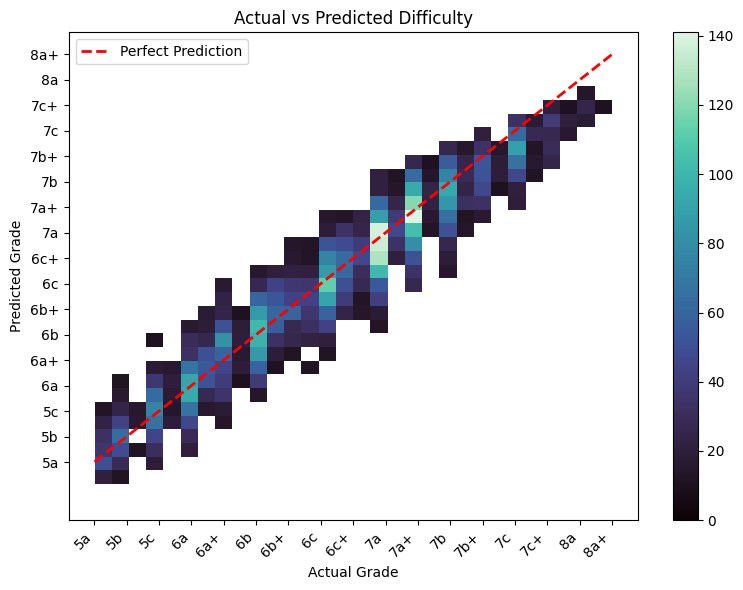


MODEL INTERPRETABILITY ANALYSIS

1. Analyzing feature importance...
Angle......................... 4.6603
Start/Finish Holds............ 1.5059
Spatial Order................. 0.0000

2. Visualizing attention for sample routes...


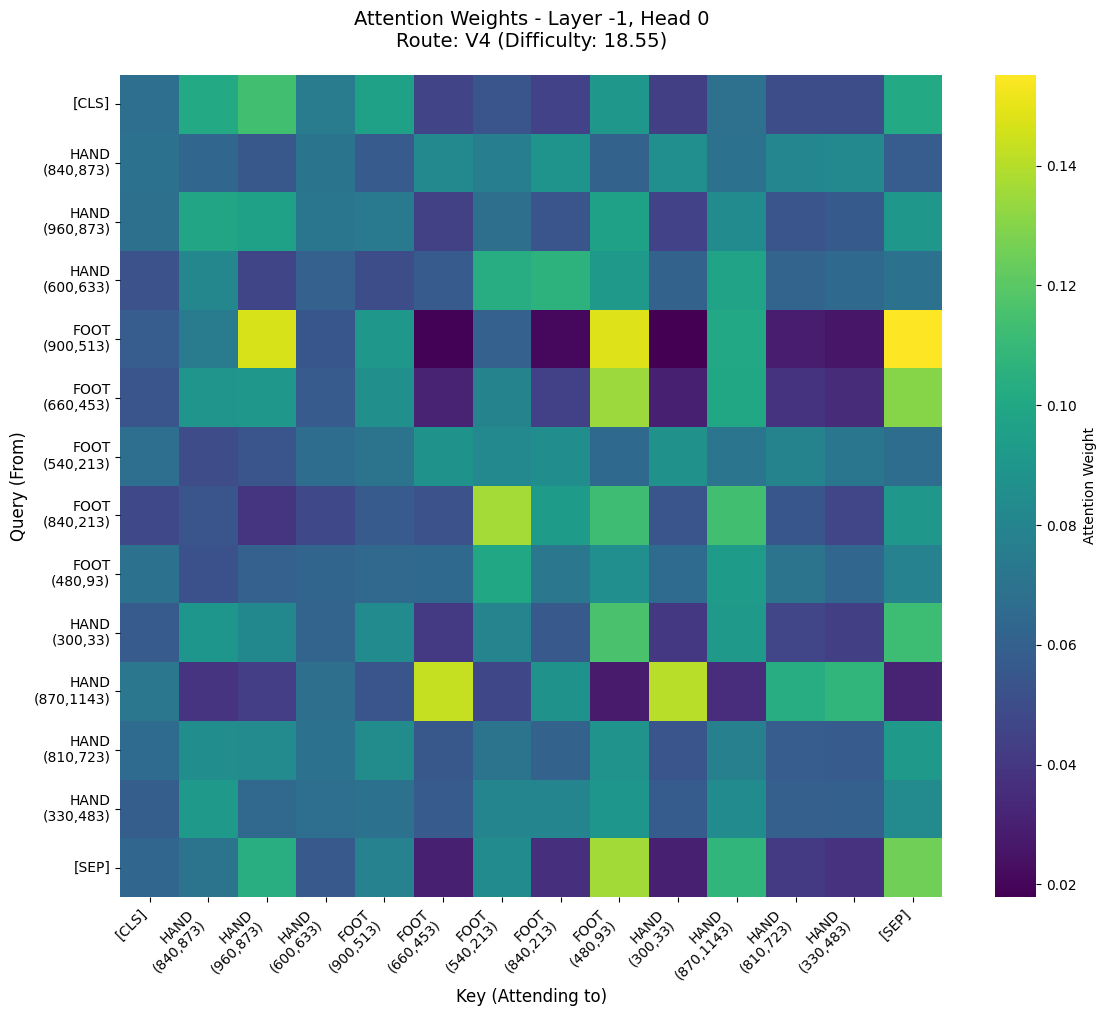


Route 0 Analysis:
Grade: V4
Predicted Difficulty: 20.21
Actual Difficulty: 18.55
Number of holds: 12
Angle: 40.0°


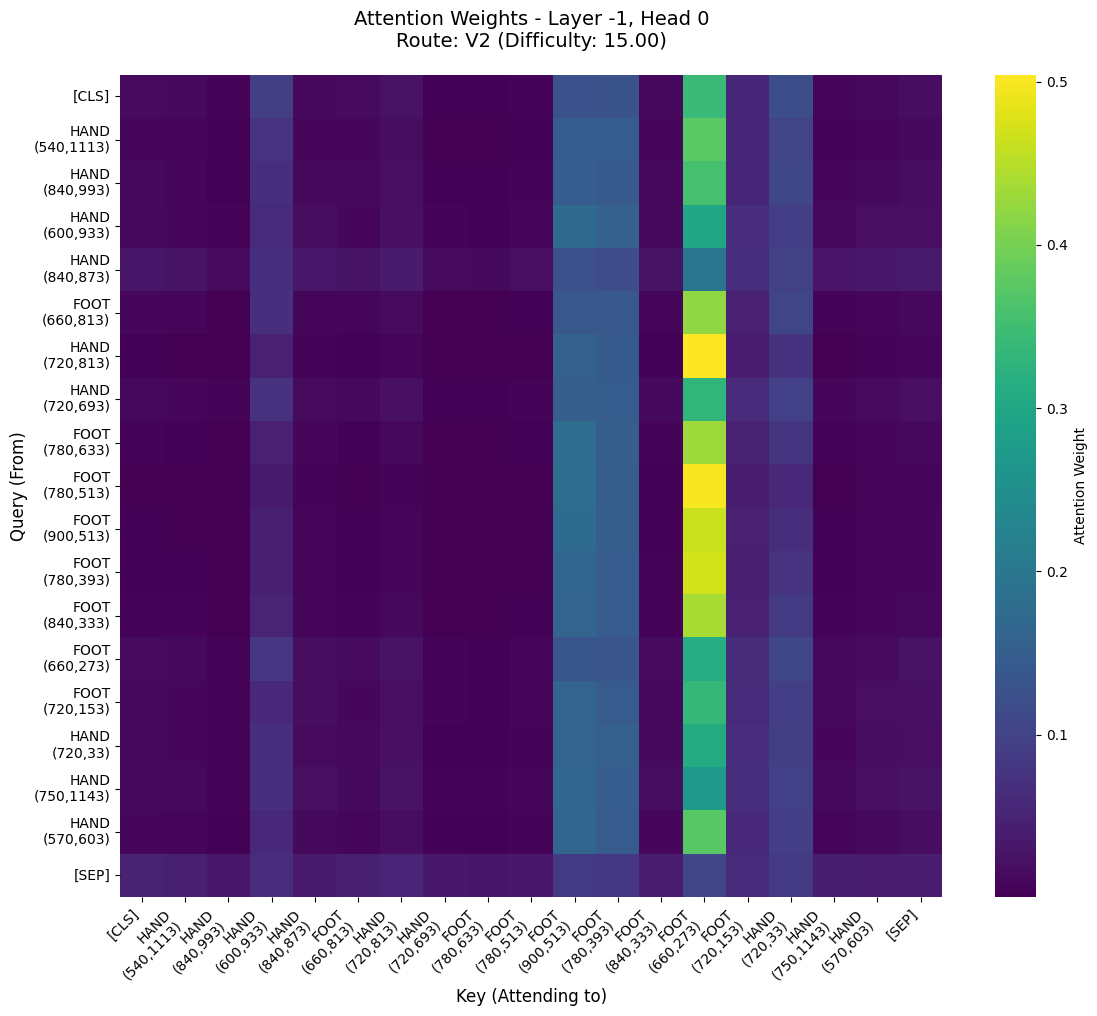


Route 1 Analysis:
Grade: V2
Predicted Difficulty: 13.19
Actual Difficulty: 15.00
Number of holds: 17
Angle: 30.0°


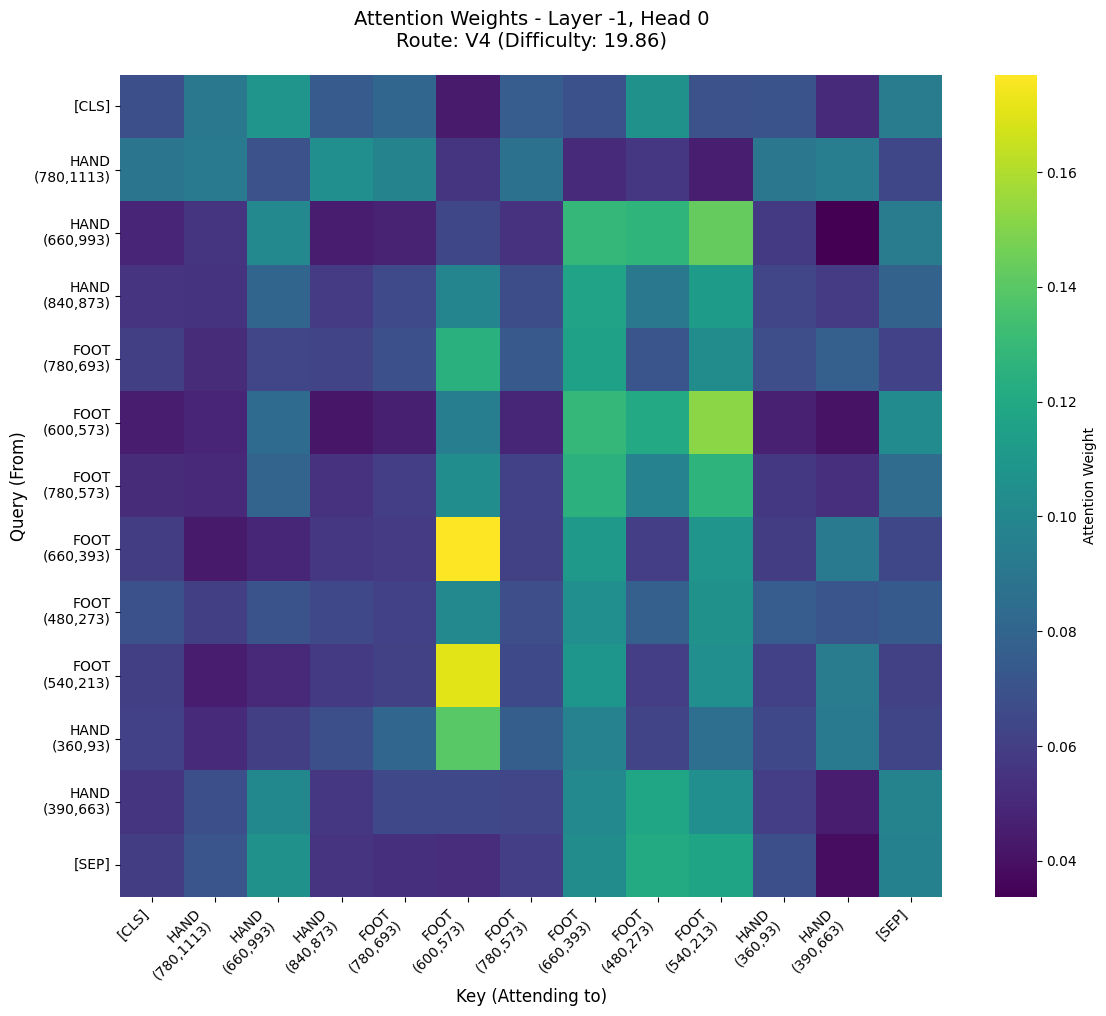


Route 2 Analysis:
Grade: V4
Predicted Difficulty: 18.87
Actual Difficulty: 19.86
Number of holds: 11
Angle: 30.0°

3. Analyzing aggregated attention patterns...


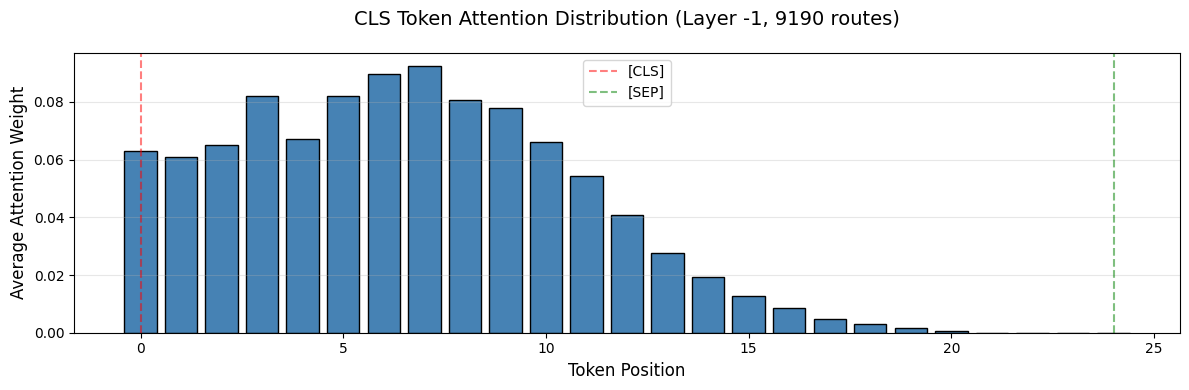


Aggregated attention analysis:
Most attended position: 7
Attention on [CLS]: 0.0630
Attention on [SEP]: 0.0000
Attention on holds (middle): 0.0407

4. Detailed route interpretations...

ROUTE INTERPRETATION - Index 7908
Grade: V6
Difficult: Predicted=21.463 | Actual=22.833
Angle: 50.0°
Hand holds: 6 | Foot holds: 5 | Route density: 0.55
Max reach: 510.88159097779203 | Avg reach: 250.4


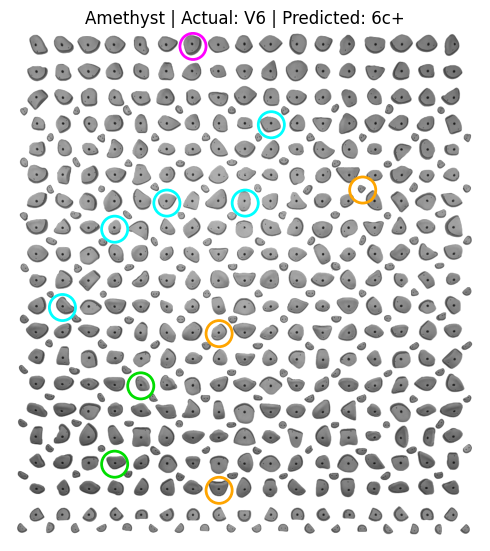


ROUTE INTERPRETATION - Index 8821
Grade: V5
Difficult: Predicted=20.576 | Actual=20.868
Angle: 50.0°
Hand holds: 13 | Foot holds: 6 | Route density: 0.68
Max reach: 1113.6426715962352 | Avg reach: 282.8


<Figure size 640x480 with 0 Axes>

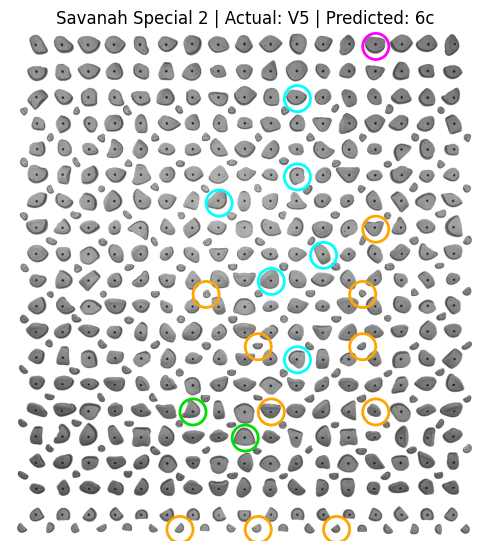


ROUTE INTERPRETATION - Index 8758
Grade: V4
Difficult: Predicted=17.135 | Actual=18.250
Angle: 45.0°
Hand holds: 9 | Foot holds: 4 | Route density: 0.69
Max reach: 853.8149682454624 | Avg reach: 255.4


<Figure size 640x480 with 0 Axes>

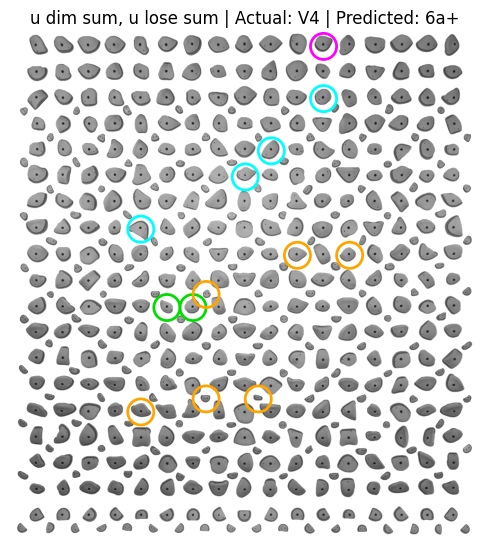


ROUTE INTERPRETATION - Index 3313
Grade: V5
Difficult: Predicted=19.733 | Actual=20.667
Angle: 30.0°
Hand holds: 6 | Foot holds: 4 | Route density: 0.60
Max reach: 819.3900170248597 | Avg reach: 370.8


<Figure size 640x480 with 0 Axes>

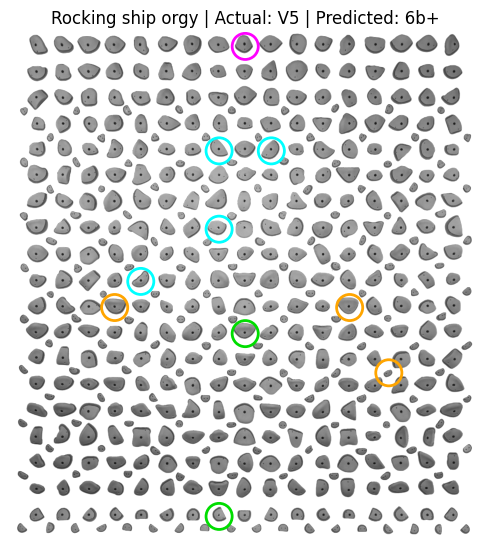


✓ All visualizations saved to 'figs/' folder


<Figure size 640x480 with 0 Axes>

In [58]:
"""
Enhanced Transformer for route difficulty prediction with spatial awareness.

1. ARCHITECTURE:
    - Added 2D positional embeddings (pos_x, pos_y)
    - Added other metadata features: route density, max reach distance
    - Separate _train_epoch, _validate, _compute_grade_weights
    - Added model_sumary
   
2. DATA PROCESSING:
   - hand_or_foot encoding instead of func(start, finish, hand, foot)
   - Sort holds by y and x
   - Data augmentation: shuffle of non-start/finish holds during training
   - Hold frequency by grade: Track how often each hold appears in different V-grades
   - Hold co-occurrence patterns: Capture which holds commonly appear together
   
3. TRAINING:
   - Early stopping 
   - Mixed precision training
   - Penalize errors more heavily on easier climbs (inverse grade weighting)

# 4. CODE QUALITY:
#    - Attention extraction: Return attention weights for visualization and interpretability
#    - Better error handling: Fixed v_grade string parsing for weight computation
#    - Cleaner data flow: Pop v_grade before moving tensors to device

"""
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import BertConfig, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter

from utils.data_processing import HOLD_ID, DataPreprocessing
from utils.evaluation import Evaluation


class SpatialKilterBERT(nn.Module):
    """BERT with 2D positional embeddings and metadata integration."""
    
    def __init__(self, vocab_size, hidden_dim=128, num_layers=4, num_heads=8, dropout=0.1):
        super().__init__()
        
        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=hidden_dim,
            num_hidden_layers=num_layers,
            num_attention_heads=num_heads,
            intermediate_size=hidden_dim * 4,
            hidden_dropout_prob=dropout,
            attention_probs_dropout_prob=dropout,
            max_position_embeddings=100,
            pad_token_id=0,
            output_attentions=True  # ADD THIS LINE
        )
        
        self.bert = BertModel(config)
        
        # 2D positional embeddings
        self.pos_x_embed = nn.Embedding(18, hidden_dim // 2)
        self.pos_y_embed = nn.Embedding(12, hidden_dim // 2)
        
        # Metadata projection
        self.angle_proj = nn.Linear(1, hidden_dim)
        self.metadata_proj = nn.Linear(2, hidden_dim)
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, input_ids, pos_x, pos_y, angle, metadata, attention_mask=None):
        # BERT embeddings - make sure to request attention outputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True,
            output_attentions=True  # ADD THIS LINE
        )
        
        # Add 2D positional embeddings
        pos_embed = torch.cat([
            self.pos_x_embed(pos_x),
            self.pos_y_embed(pos_y)
        ], dim=-1)
        
        spatial_hidden = outputs.last_hidden_state + pos_embed
        cls_token = spatial_hidden[:, 0]
        
        # Combine with metadata
        angle_emb = self.angle_proj(angle)
        meta_emb = self.metadata_proj(metadata)
        combined = torch.cat([cls_token + angle_emb, meta_emb], dim=-1)
        
        return self.regressor(combined).squeeze(-1), outputs.attentions  # Return attentions

class EnhancedBoulderDataset(Dataset):
    """Dataset with spatial features and augmentation."""
    
    def __init__(self, routes_df, vocab, hold_stats, max_length=25, augment=False):
        self.routes = routes_df.reset_index(drop=True)
        self.vocab = vocab
        self.hold_stats = hold_stats
        self.max_length = max_length
        self.augment = augment
    
    def __len__(self):
        return len(self.routes)
    
    def __getitem__(self, idx):
        row = self.routes.iloc[idx]
        holds = row['holds_data']
        
        # Sort holds by position (y first for climbing, then x)
        holds_sorted = sorted(holds, key=lambda h: (
            list(h.values())[0] not in [14, 15],  # Start/finish first
            -list(h.keys())[0] // 100,  # y coordinate (descending)
            list(h.keys())[0] % 100  # x coordinate
        ))
        
        # Augment: shuffle non-start/finish holds
        if self.augment and len(holds_sorted) > 2:
            start_finish = [h for h in holds_sorted if list(h.values())[0] in [14, 15]]
            middle = [h for h in holds_sorted if list(h.values())[0] not in [14, 15]]
            np.random.shuffle(middle)
            holds_sorted = start_finish + middle
        
        tokens, pos_x, pos_y = self._tokenize_with_positions(holds_sorted)
        
        # Metadata features
        density = len(holds) / self.max_length
        reaches = [abs(holds_sorted[i+1][list(holds_sorted[i+1].keys())[0]] - 
                      holds_sorted[i][list(holds_sorted[i].keys())[0]]) 
                  for i in range(len(holds_sorted)-1)]
        max_reach = max(reaches) / 1000 if reaches else 0
        
        angle = row['angle_y'] if not pd.isna(row['angle_y']) else 0.0
        difficulty = row['display_difficulty']
        
        # Pad sequences
        attention_mask = [1] * len(tokens)
        pad_len = self.max_length - len(tokens)
        tokens.extend([0] * pad_len)
        pos_x.extend([0] * pad_len)
        pos_y.extend([0] * pad_len)
        attention_mask.extend([0] * pad_len)
        
        return {
            'input_ids': torch.LongTensor(tokens[:self.max_length]),
            'pos_x': torch.LongTensor(pos_x[:self.max_length]),
            'pos_y': torch.LongTensor(pos_y[:self.max_length]),
            'angle': torch.FloatTensor([angle]),
            'metadata': torch.FloatTensor([density, max_reach]),
            'attention_mask': torch.FloatTensor(attention_mask[:self.max_length]),
            'difficulty': torch.FloatTensor([difficulty]),
            'v_grade': row['v_grade']
        }
    
    def _tokenize_with_positions(self, holds):
        """Convert holds to tokens with 2D positions."""
        tokens = [1]  # [CLS]
        pos_x = [0]
        pos_y = [0]
        
        for hold in holds[:(self.max_length - 2)]:
            hold_id, func = list(hold.items())[0]
            
            # Binary encoding: foot (13) vs hand/start/finish
            hand_or_foot = 0 if func == 13 else 1
            token = self.vocab.get(f"{hold_id}_{hand_or_foot}", 0)
            tokens.append(token)
            
            # Extract x, y coordinates
            x = hold_id % 100
            y = hold_id // 100
            pos_x.append(min(x, 17))
            pos_y.append(min(y, 11))
        
        tokens.append(2)  # [SEP]
        pos_x.append(0)
        pos_y.append(0)
        
        return tokens, pos_x, pos_y


class EnhancedKilterEncoder:
    """Enhanced encoder with hold statistics and training improvements."""
    
    def __init__(self, model_name='enhanced_transformer', hidden_dim=128, num_layers=4):
        self.model_name = model_name
        self.max_length = 25
        self.vocab = self._build_vocab()
        self.hold_stats = {}
        self.model = SpatialKilterBERT(len(self.vocab), hidden_dim, num_layers)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.scaler = GradScaler()
    
    def _build_vocab(self):
        """Build vocabulary with hand_or_foot encoding."""
        vocab = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2}
        token_id = 3
        for hold_id in HOLD_ID:
            for hand_or_foot in [0, 1]:  # 0=foot, 1=hand/start/finish
                vocab[f"{hold_id}_{hand_or_foot}"] = token_id
                token_id += 1
        return vocab
    
    def compute_hold_statistics(self, routes_df):
        """Compute hold frequency and co-occurrence by grade."""
        hold_freq = {grade: Counter() for grade in routes_df['v_grade'].unique()}
        hold_cooccur = Counter()
        
        for _, row in routes_df.iterrows():
            grade = row['v_grade']
            holds = [list(h.items())[0] for h in row['holds_data']]
            
            # Frequency by grade
            for hold_id, func in holds:
                hand_or_foot = 0 if func == 13 else 1
                hold_freq[grade][f"{hold_id}_{hand_or_foot}"] += 1
            
            # Co-occurrence
            for i in range(len(holds)):
                for j in range(i+1, len(holds)):
                    hf1 = 0 if holds[i][1] == 13 else 1
                    hf2 = 0 if holds[j][1] == 13 else 1
                    pair = tuple(sorted([f"{holds[i][0]}_{hf1}", f"{holds[j][0]}_{hf2}"]))
                    hold_cooccur[pair] += 1
        
        self.hold_stats = {'frequency': hold_freq, 'cooccurrence': hold_cooccur}
        return self.hold_stats
    
    def train_model(self, train_df, val_df, epochs=30, batch_size=64, lr=2e-4, early_stop=3):
        """Train with mixed precision and early stopping."""
        # Compute statistics
        self.compute_hold_statistics(train_df)
        
        train_dataset = EnhancedBoulderDataset(train_df, self.vocab, self.hold_stats, augment=True)
        val_dataset = EnhancedBoulderDataset(val_df, self.vocab, self.hold_stats, augment=False)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, 
            num_warmup_steps=len(train_loader) * epochs // 10,
            num_training_steps=len(train_loader) * epochs
        )
        
        # Weighted loss: penalize more on easier climbs
        grade_weights = self._compute_grade_weights(train_df)
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        print(f"Training {self.model_name}")
        
        for epoch in range(epochs):
            # Training
            train_loss = self._train_epoch(train_loader, optimizer, scheduler, grade_weights, epoch, epochs)
            
            # Validation
            val_loss = self._validate(val_loader, grade_weights)
            
            print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
                f"LR: {scheduler.get_last_lr()[0]:.2e}")
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                self.save_model()
            else:
                patience_counter += 1
                if patience_counter >= early_stop:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    def _train_epoch(self, loader, optimizer, scheduler, grade_weights, epoch, total_epochs):
        """Single training epoch with mixed precision."""
        self.model.train()
        total_loss = 0
        
        for batch in tqdm(loader, desc=f"Epoch {epoch+1}/{total_epochs}", leave=False):
            v_grades = batch.pop('v_grade')
            batch = {k: v.to(self.device) for k, v in batch.items()}
            
            optimizer.zero_grad()
            
            with autocast():
                pred, _ = self.model(
                    batch['input_ids'], batch['pos_x'], batch['pos_y'],
                    batch['angle'], batch['metadata'], batch['attention_mask']
                )
                
                # Weighted loss
                weights = torch.tensor([grade_weights.get(g, 1.0) for g in v_grades], 
                                    device=self.device)
                loss = (nn.SmoothL1Loss(reduction='none')(pred, batch['difficulty'].squeeze()) * weights).mean()
            
            self.scaler.scale(loss).backward()
            self.scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.scaler.step(optimizer)
            self.scaler.update()
            scheduler.step()
            
            total_loss += loss.item()
        
        return total_loss / len(loader)
    
    def _validate(self, loader, grade_weights):
        """Validation with weighted loss."""
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for batch in loader:
                v_grades = batch.pop('v_grade')
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                pred, _ = self.model(
                    batch['input_ids'], batch['pos_x'], batch['pos_y'],
                    batch['angle'], batch['metadata'], batch['attention_mask']
                )
                
                weights = torch.tensor([grade_weights.get(g, 1.0) for g in v_grades], 
                                      device=self.device)
                loss = (nn.SmoothL1Loss(reduction='none')(pred, batch['difficulty'].squeeze()) * weights).mean()
                total_loss += loss.item()
        
        return total_loss / len(loader)
    
    def _compute_grade_weights(self, df):
        """Compute weights to penalize errors on easier grades more."""
        grade_counts = df['v_grade'].value_counts()
        
        # Extract numeric part from grade strings like 'V5', 'V7+'
        def grade_to_num(grade_str):
            import re
            match = re.search(r'\d+', str(grade_str))
            return int(match.group()) if match else 0
        
        max_grade_num = max(grade_to_num(g) for g in grade_counts.index)
        
        # Higher weight for lower grades
        weights = {grade: (max_grade_num - grade_to_num(grade) + 1) / max_grade_num 
                  for grade in grade_counts.index}
        return weights
    
    def save_model(self):
        torch.save({
            'model_state': self.model.state_dict(),
            'vocab': self.vocab,
            'hold_stats': self.hold_stats
        }, f'saved_models/{self.model_name}.pt')
    
    def load_model(self, path=None):
        if path is None:
            path = self.model_name
        checkpoint = torch.load(f'saved_models/{path}.pt', map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state'])
        self.vocab = checkpoint['vocab']
        self.hold_stats = checkpoint.get('hold_stats', {})
        self.model.eval()
    
    def model_summary(self):
        """Print model architecture and parameters."""
        print(f"\n{'='*60}")
        print(f"Model: {self.model_name}")
        print(f"{'='*60}")
        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Max sequence length: {self.max_length}")
        
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        print(f"\nTotal parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Model size: {total_params * 4 / 1024**2:.2f} MB")
        
        print(f"\nArchitecture:")
        for name, module in self.model.named_children():
            params = sum(p.numel() for p in module.parameters())
            print(f"  {name}: {params:,} parameters")
        print(f"{'='*60}\n")

    def predict(self, routes_df, batch_size=64, return_attention=False):
        """Predict with attention extraction."""
        dataset = EnhancedBoulderDataset(routes_df, self.vocab, self.hold_stats, augment=False)
        loader = DataLoader(dataset, batch_size=batch_size)
        
        self.model.eval()
        predictions = []
        all_attentions = []
        
        with torch.no_grad():
            for batch in loader:
                batch.pop('v_grade')
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                pred, attn = self.model(
                    batch['input_ids'], batch['pos_x'], batch['pos_y'],
                    batch['angle'], batch['metadata'], batch['attention_mask']
                )
                
                predictions.extend(pred.cpu().numpy())
                if attn and return_attention:
                    # attn is a tuple of attention weights from each layer
                    # Each has shape: (batch_size, num_heads, seq_len, seq_len)
                    all_attentions.append([a.cpu().numpy() for a in attn])
        
        return np.array(predictions), all_attentions if return_attention else None


    def visualize_attention(self, route_df, route_idx=0, layer=-1, head=0):
        """
        Visualize attention weights for a specific route.
        
        Args:
            route_df: DataFrame with routes
            route_idx: Index of route to visualize
            layer: Which transformer layer (-1 for last layer)
            head: Which attention head to visualize
        """
      
        # Get single route
        single_route = route_df.iloc[[route_idx]]
        
        # Get predictions and attention
        _, attentions = self.predict(single_route, batch_size=1, return_attention=True)
        
        if not attentions:
            print("No attention weights available. Make sure model returns attention.")
            return
        
        # Extract attention weights: [batch][layer][batch_idx, num_heads, seq_len, seq_len]
        attn_weights = attentions[0][layer][0, head]  # Shape: (seq_len, seq_len)
        
        # Get route info
        route = single_route.iloc[0]
        holds = route['holds_data']
        
        # Create labels for holds
        labels = ['[CLS]']
        for hold in holds[:self.max_length-2]:
            hold_id, func = list(hold.items())[0]
            idx = HOLD_ID.index(hold_id)
            x, y = HOLDCOORDINATES[idx]
            func_name = 'FOOT' if func == 13 else 'HAND'
            labels.append(f"{func_name}\n({x},{y})")
        labels.append('[SEP]')
        
        # Trim to actual sequence length
        seq_len = len(labels)
        attn_weights = attn_weights[:seq_len, :seq_len]
        
        # Plot heatmap
        plt.figure(figsize=(12,10))
        sns.heatmap(attn_weights, 
                    xticklabels=labels, 
                    yticklabels=labels,
                    cmap='viridis', 
                    cbar_kws={'label': 'Attention Weight'},
                    square=True)
        
        plt.title(f'Attention Weights - Layer {layer}, Head {head}\n'
                f'Route: {route["v_grade"]} (Difficulty: {route["display_difficulty"]:.2f})', 
                fontsize=14, pad=20)
        plt.xlabel('Key (Attending to)', fontsize=12)
        plt.ylabel('Query (From)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(f'figs/attention_route_{route_idx}_layer_{layer}_head_{head}.png', 
                    dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\nRoute {route_idx} Analysis:")
        print(f"Grade: {route['v_grade']}")
        print(f"Predicted Difficulty: {self.predict(single_route)[0][0]:.2f}")
        print(f"Actual Difficulty: {route['display_difficulty']:.2f}")
        print(f"Number of holds: {len(holds)}")
        print(f"Angle: {route['angle_y']:.1f}°")


    def analyze_feature_importance(self, routes_df, sample_size=100):
        """
        Analyze feature importance using perturbation analysis.
        
        Tests impact of removing/zeroing different features on predictions.
        """
        import matplotlib.pyplot as plt
        
        # Sample routes
        sample_df = routes_df.sample(min(sample_size, len(routes_df)), random_state=42)
        
        # Baseline predictions
        baseline_preds, _ = self.predict(sample_df)
        
        results = {}
        
        # Test 1: Remove angle information
        temp_df = sample_df.copy()
        temp_df['angle_y'] = 0.0
        preds_no_angle, _ = self.predict(temp_df)
        results['Angle'] = np.mean(np.abs(baseline_preds - preds_no_angle))
        
        # Test 2: Shuffle hold positions (test spatial importance)
        temp_df = sample_df.copy()
        def shuffle_holds(holds_data):
            import random
            holds = holds_data.copy()
            random.shuffle(holds)
            return holds
        temp_df['holds_data'] = temp_df['holds_data'].apply(shuffle_holds)
        preds_shuffled, _ = self.predict(temp_df)
        results['Spatial Order'] = np.mean(np.abs(baseline_preds - preds_shuffled))
        
        # Test 3: Remove first/last holds (test start/finish importance)
        temp_df = sample_df.copy()
        def remove_start_finish(holds_data):
            return [h for h in holds_data if list(h.values())[0] not in [14, 15]]
        temp_df['holds_data'] = temp_df['holds_data'].apply(remove_start_finish)
        preds_no_sf, _ = self.predict(temp_df)
        results['Start/Finish Holds'] = np.mean(np.abs(baseline_preds - preds_no_sf))
        
        
        for feature, importance in sorted(results.items(), key=lambda x: x[1], reverse=True):
            print(f"{feature:.<30} {importance:.4f}")
        
        
        return results


    def visualize_attention_aggregated(self, routes_df, num_routes=100, layer=-1):
        """
        Visualize aggregated attention patterns across multiple routes.
        Shows which positions (start, middle, end) get most attention.
        """
        
        grade_counts = routes_df['v_grade'].value_counts()
        total_routes = min(num_routes, len(routes_df))
        
        sample_routes = []
        for grade in grade_counts.index:
            grade_df = routes_df[routes_df['v_grade'] == grade]
            # Proportional sampling
            n_samples = max(1, int(total_routes * len(grade_df) / len(routes_df)))
            n_samples = min(n_samples, len(grade_df))  # Don't oversample
            sampled = grade_df.sample(n=n_samples, random_state=42)
            sample_routes.append(sampled)
        
        sample_routes = pd.concat(sample_routes).sample(frac=1, random_state=42)  # Shuffle
        sample_routes = sample_routes.iloc[:total_routes]  # Trim to exact number
        
        # sample_routes = routes_df.sample(min(num_routes, len(routes_df)), random_state=42)
        
        all_cls_attentions = []
        
        for idx in range(len(sample_routes)):
            route_df = sample_routes.iloc[[idx]]
            _, attentions = self.predict(route_df, batch_size=1, return_attention=True)
            
            if attentions:
                # Get CLS token attention (first row) averaged across heads
                attn = attentions[0][layer][0]  # (num_heads, seq_len, seq_len)
                cls_attn = attn[:, 0, :].mean(axis=0)  # Average across heads, take CLS row
                all_cls_attentions.append(cls_attn)
        
        if not all_cls_attentions:
            print("No attention weights available.")
            return
        
        # Pad to same length and average
        max_len = max(len(a) for a in all_cls_attentions)
        padded = np.zeros((len(all_cls_attentions), max_len))
        
        for i, attn in enumerate(all_cls_attentions):
            padded[i, :len(attn)] = attn
        
        avg_attention = padded.mean(axis=0)
        
        # Plot
        plt.figure(figsize=(12, 4))
        positions = np.arange(len(avg_attention))
        plt.bar(positions, avg_attention, color='steelblue', edgecolor='black')
        plt.xlabel('Token Position', fontsize=12)
        plt.ylabel('Average Attention Weight', fontsize=12)
        plt.title(f'CLS Token Attention Distribution (Layer {layer}, {min(num_routes, len(routes_df))} routes)', 
                fontsize=14, pad=20)
        plt.grid(axis='y', alpha=0.3)
        
        # Highlight special tokens
        plt.axvline(0, color='red', linestyle='--', alpha=0.5, label='[CLS]')
        if len(avg_attention) > 1:
            plt.axvline(len(avg_attention)-1, color='green', linestyle='--', alpha=0.5, label='[SEP]')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('figs/attention_aggregated.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\nAggregated attention analysis:")
        print(f"Most attended position: {np.argmax(avg_attention)}")
        print(f"Attention on [CLS]: {avg_attention[0]:.4f}")
        print(f"Attention on [SEP]: {avg_attention[-1]:.4f}")
        print(f"Attention on holds (middle): {avg_attention[1:-1].mean():.4f}")


    def interpret_route(self, route_df, route_idx=0):
        """
        Comprehensive interpretation of model's prediction for a single route.
        """
        
        single_route = route_df.iloc[[route_idx]]
        route = single_route.iloc[0]
        
        # Get prediction
        pred, attentions = self.predict(single_route, return_attention=True)
        pred_diff = pred[0]
        actual_diff = route['display_difficulty']
        
        holds = route['holds_data']
        
        print("\n" + "="*70)
        print(f"ROUTE INTERPRETATION - Index {route_idx}")
        print("="*70)
        print(f"Grade: {route['v_grade']}")
        print(f"Difficult: Predicted={pred_diff:.3f} | Actual={actual_diff:.3f}")
        print(f"Angle: {route['angle_y']:.1f}°")

        # Analyze holds
        hand_holds = sum(1 for h in holds if list(h.values())[0] != 13)
        foot_holds = sum(1 for h in holds if list(h.values())[0] == 13)
        density = hand_holds / (hand_holds+foot_holds)
        print(f"Hand holds: {hand_holds} | Foot holds: {foot_holds} | Route density: {density:.2f}")
        

        # Calculate reaches
        reaches = []
        for i in range(len(holds)-1):
            h1_id = list(holds[i].keys())[0]
            idx_1 = HOLD_ID.index(h1_id)
            x1, y1 = HOLDCOORDINATES[idx_1]
            
            h2_id = list(holds[i+1].keys())[0]
            idx_2 = HOLD_ID.index(h2_id)
            x2, y2 = HOLDCOORDINATES[idx_2]
            
            reach = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            reaches.append(reach)
        
        if reaches:
            print(f"Max reach: {max(reaches)} | Avg reach: {np.mean(reaches):.1f}")
        
       
        print("="*70)
        
        # Visualize route layout
        from utils.visualization import Visualization
        viz = Visualization()
        viz.plot_boulder(holds, name=route['name'], v_grade=route['v_grade'], predicted_v_grade=dp.difficulty_to_grades(pred_diff)[0])


# Update main function to include visualizations

"""Training and evaluation pipeline."""
import os
os.makedirs('figs', exist_ok=True)

# Load data
dp = DataPreprocessing()
routes = dp.load_routes()

# Split data
train_df, test_df = train_test_split(routes, test_size=0.15, random_state=42, 
                                        stratify=routes['v_grade'])
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42,
                                    stratify=train_df['v_grade'])

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# Train
encoder = EnhancedKilterEncoder(hidden_dim=128, num_layers=4)
encoder.model_summary()

# encoder.train_model(train_df, val_df, epochs=50, batch_size=64, lr=2e-4, early_stop=3)

# Evaluate
encoder.load_model()
y_test = test_df['display_difficulty'].values
y_pred, _ = encoder.predict(test_df)

evaluator = Evaluation(dp)
evaluator.get_scores(y_test, y_pred, "Enhanced Spatial Transformer")
evaluator.plot_predictions(y_test, y_pred)


print("\n" + "="*70)
print("MODEL INTERPRETABILITY ANALYSIS")
print("="*70)

print("\n1. Analyzing feature importance...")
encoder.analyze_feature_importance(test_df, sample_size=100)


print("\n2. Visualizing attention for sample routes...")
for i in range(3):  # Visualize 3 routes
    encoder.visualize_attention(test_df, route_idx=i, layer=-1, head=0)


print("\n3. Analyzing aggregated attention patterns...")
encoder.visualize_attention_aggregated(test_df, num_routes=len(test_df), layer=-1)


print("\n4. Detailed route interpretations...")
for i in np.random.choice(len(test_df), 4, replace=False):  # Visualize 4 random routes
    encoder.interpret_route(test_df, route_idx=i)



